<center><h1> --- Setting Up --- </h1></center><br>

## Import libraries

In [1]:
#----------------------Basic libraries for data manipulation
#import pandas; data manipulation
import pandas as pd

#import numpy; arrays and computing
import numpy as np

#import date~ libraries; deal with date-time columns
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date

#import regex; string matching searches
import regex

#import warnings library; ignore warnings
import warnings
warnings.filterwarnings('ignore')

#remove display dimension limiter for pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#----------------------Libraries for validation/model selection
#import train_test_split; split data in test and train set
#import cross_validate; perform cross_validation
#import RandomizedSearchCV; hyperparameter tuning
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV  

#----------------------Libraries for visualization
#import seaborn; visualization
import seaborn as sns

#import matplotlib; visualization
import matplotlib.pyplot as plt
%matplotlib inline

#----------------------Libraries for cleaning data
#import make_column_transformer; apply transformer on columns of the data
#import make_column_selector; create callable to specify which columns to use in col transformer 
#import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer

#----------------------Libraries for imputation
#import KNNImputer; imputing missing values
#import MissingIndicator; create binary flags for missing values
from sklearn.impute import KNNImputer, MissingIndicator

#----------------------Libraries for feature-scaling
#import StandardScaler; standardize data set
from sklearn.preprocessing import StandardScaler

#----------------------Libraries for feature selection/importance
#import VarianceThreshold; feature selection using variance as metric
#import mutual_info_classif; feature selection using mutual info/info gain as the metric
#import SelectKBest; feature selection + feature importance
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest

#----------------------Libraries for modelling
#import RandomForestClassifier; classification with Random Forest model/algorithm
from sklearn.ensemble import RandomForestClassifier

#----------------------Libraries for evaluating the model; the metrics
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score

## Load data

In [2]:
#load 'train' data set from github repo; use this to train the model
train= pd.read_csv('https://raw.githubusercontent.com/ytz825/Pitney-Bowes-Data-Challenge/main/train.csv')

#load 'test' data set from github repo; use this as out of sample validation
test = pd.read_csv('https://raw.githubusercontent.com/ytz825/Pitney-Bowes-Data-Challenge/main/test.csv')

___

<center><h1> --- Getting Familiar with the Data --- </h1></center> <br>

In [3]:
#preliminary look at the data set
#train.head()

#inspect meta data of the data set
#train.info()

#look at summary statistics of the data set
#test.describe()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   deviceid                     4500 non-null   int64  
 1   avg_time_charging_lag1       4500 non-null   float64
 2   avg_time_charging_lag2       4500 non-null   float64
 3   avg_time_charging_lag3       4500 non-null   float64
 4   avg_time_charging_lag7       4497 non-null   float64
 5   charging_rate_lag3           4500 non-null   float64
 6   charging_rate_lag7           4499 non-null   float64
 7   avg_time_discharging_lag1    4500 non-null   float64
 8   avg_time_discharging_lag2    4500 non-null   float64
 9   avg_time_discharging_lag3    4500 non-null   float64
 10  avg_time_discharging_lag7    4497 non-null   float64
 11  discharging_rate_lag3        4500 non-null   float64
 12  discharging_rate_lag7        4499 non-null   float64
 13  charge_cycle_time_

In [4]:
#Is the LastRecord date the same for all rows?
train.LastRecord.value_counts()

4/1/2021    40500
Name: LastRecord, dtype: int64

In [5]:
#look at the shape of the data
train.shape

(40500, 55)

<u>**Based on the preliminary view of the data, what observations can we make?**</u>

- The data set is mostly comprised of numerical columns outside of 1 column with boolean values and 2 other columns with object data type values.

- It seems like there is a huge disparity in the scales of columns; there are columns that are in the tens, hundreds, and thousands range of varying magnitudes.

## Visualizing the data

### Create subsets of data set for visualization purposes

In [6]:
#create a subset dataframe consisting of just the numerical columns of the 'train' data set
numeric_columns = train.select_dtypes('number')

#create a subset dataframe consisting of just the non-numerical columns of the 'train' data set
non_numeric_columns = train.select_dtypes(exclude = 'number')

In [7]:
#check shape of the numeric_columns subset data frame and the non_numeric_columns subset data frame
numeric_columns.shape, non_numeric_columns.shape

((40500, 52), (40500, 3))

### Looking at the shape of each predictor

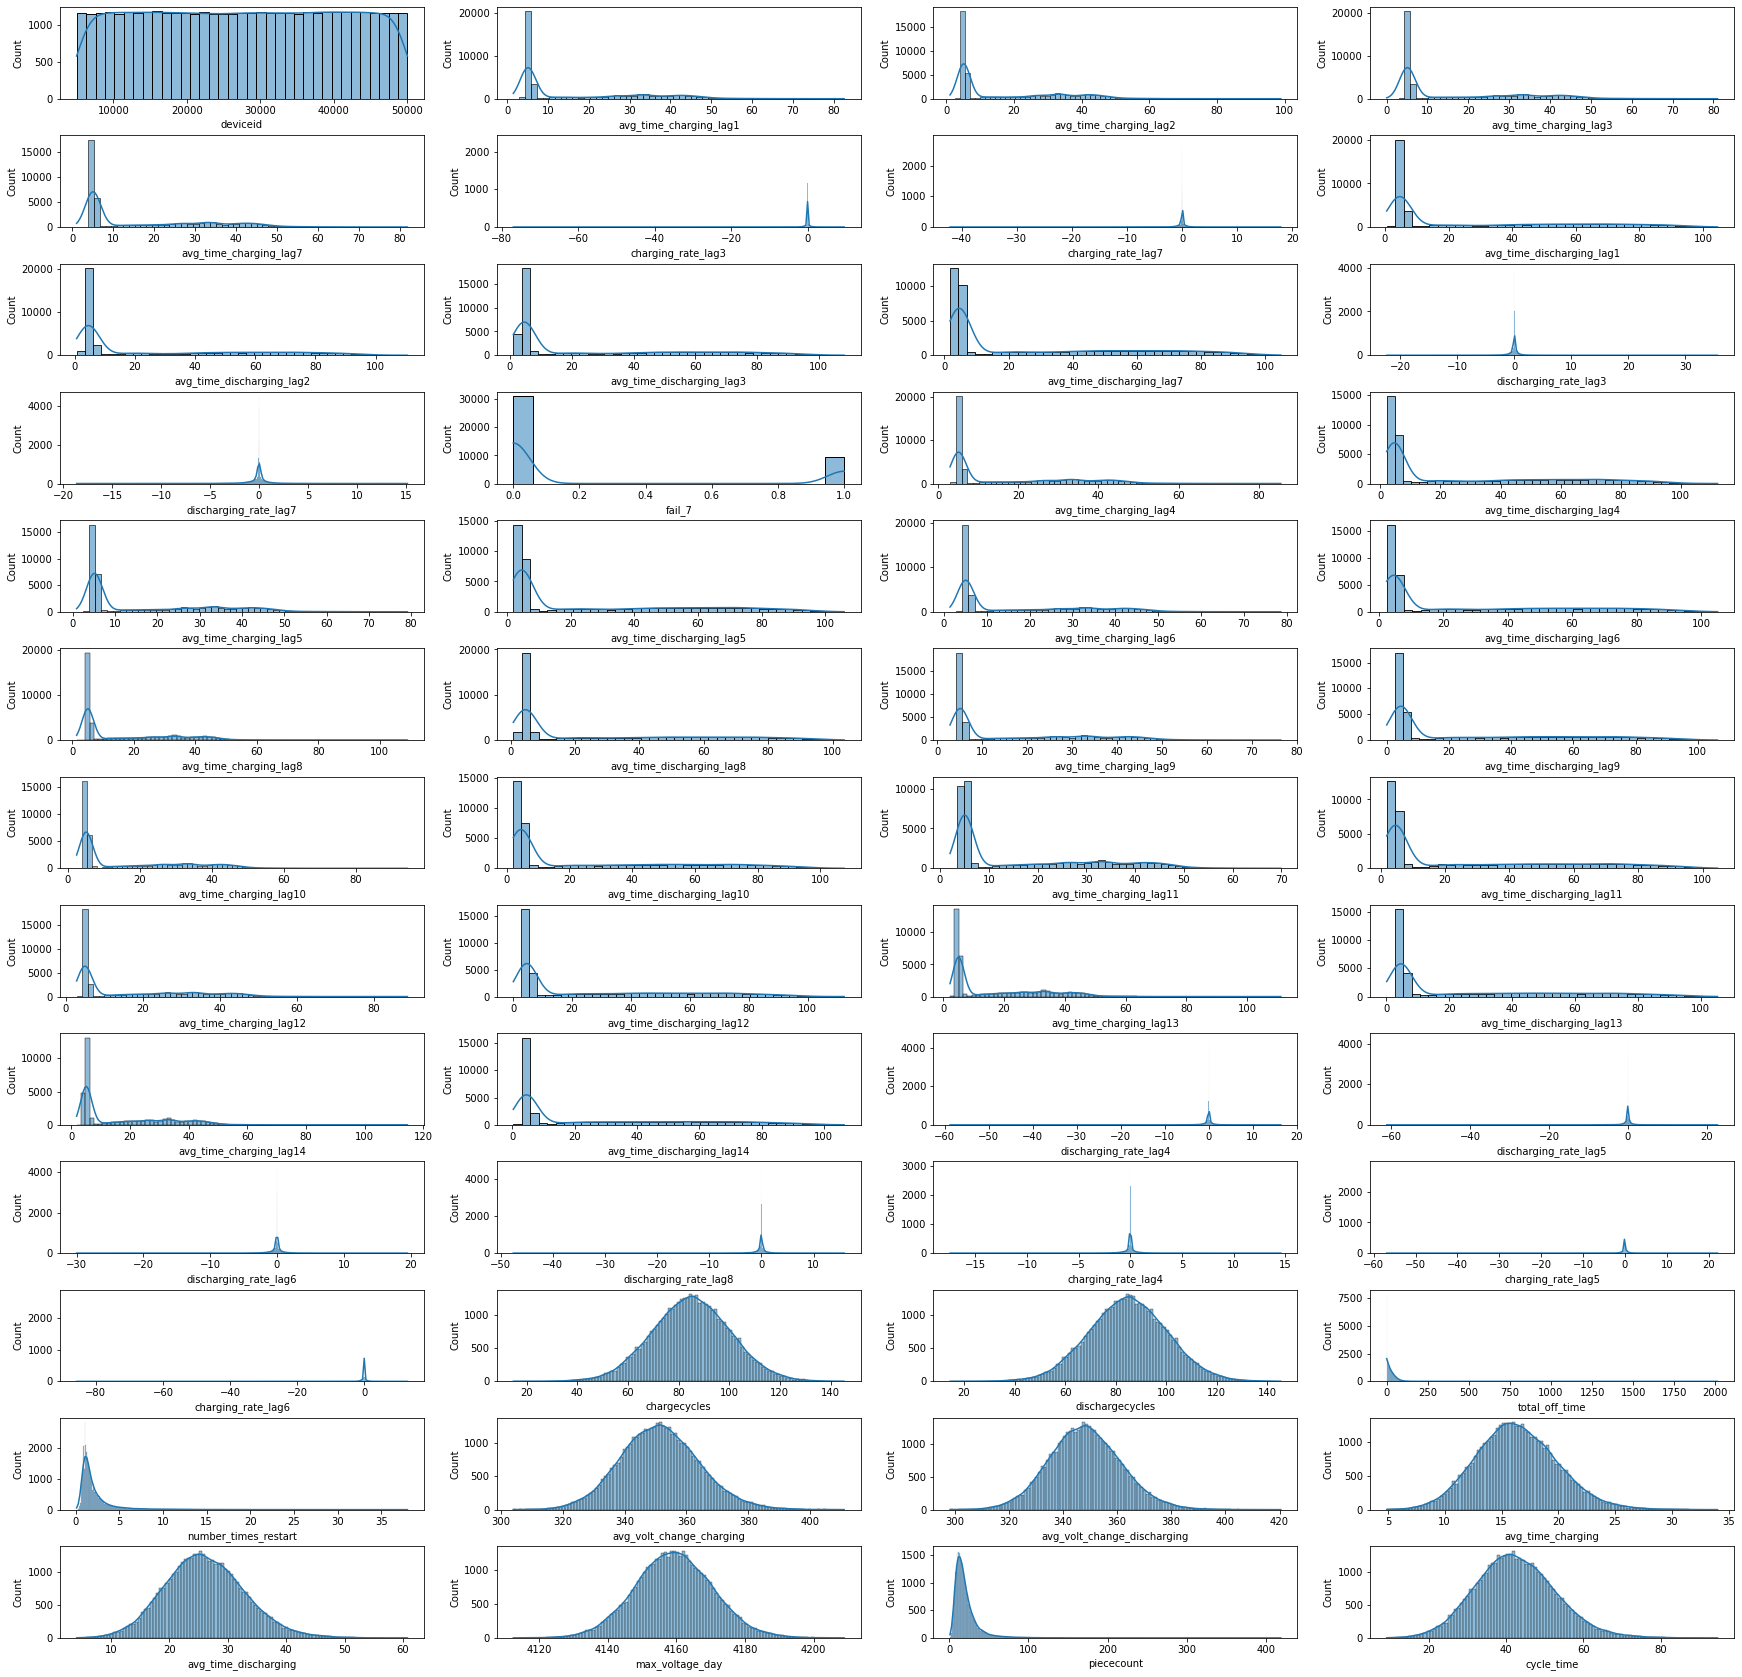

In [8]:
#create a function that creates a histogram + kde distribution line graph for every numerical predictor variable
def xhist(df):
    f = plt.figure(figsize=(30,30))

    for i in range(len(df.columns)):
        f.add_subplot(13, 4, i+1)
        sns.histplot(data=numeric_columns, x=df.columns[i], kde=True)
        plt.xlabel(df.columns[i])
        plt.subplots_adjust(hspace=0.4)

    plt.show()

#call the xhist() function; create the histogram + kde distribution line graphs
xhist(numeric_columns)

### Closer look at the spread of the data

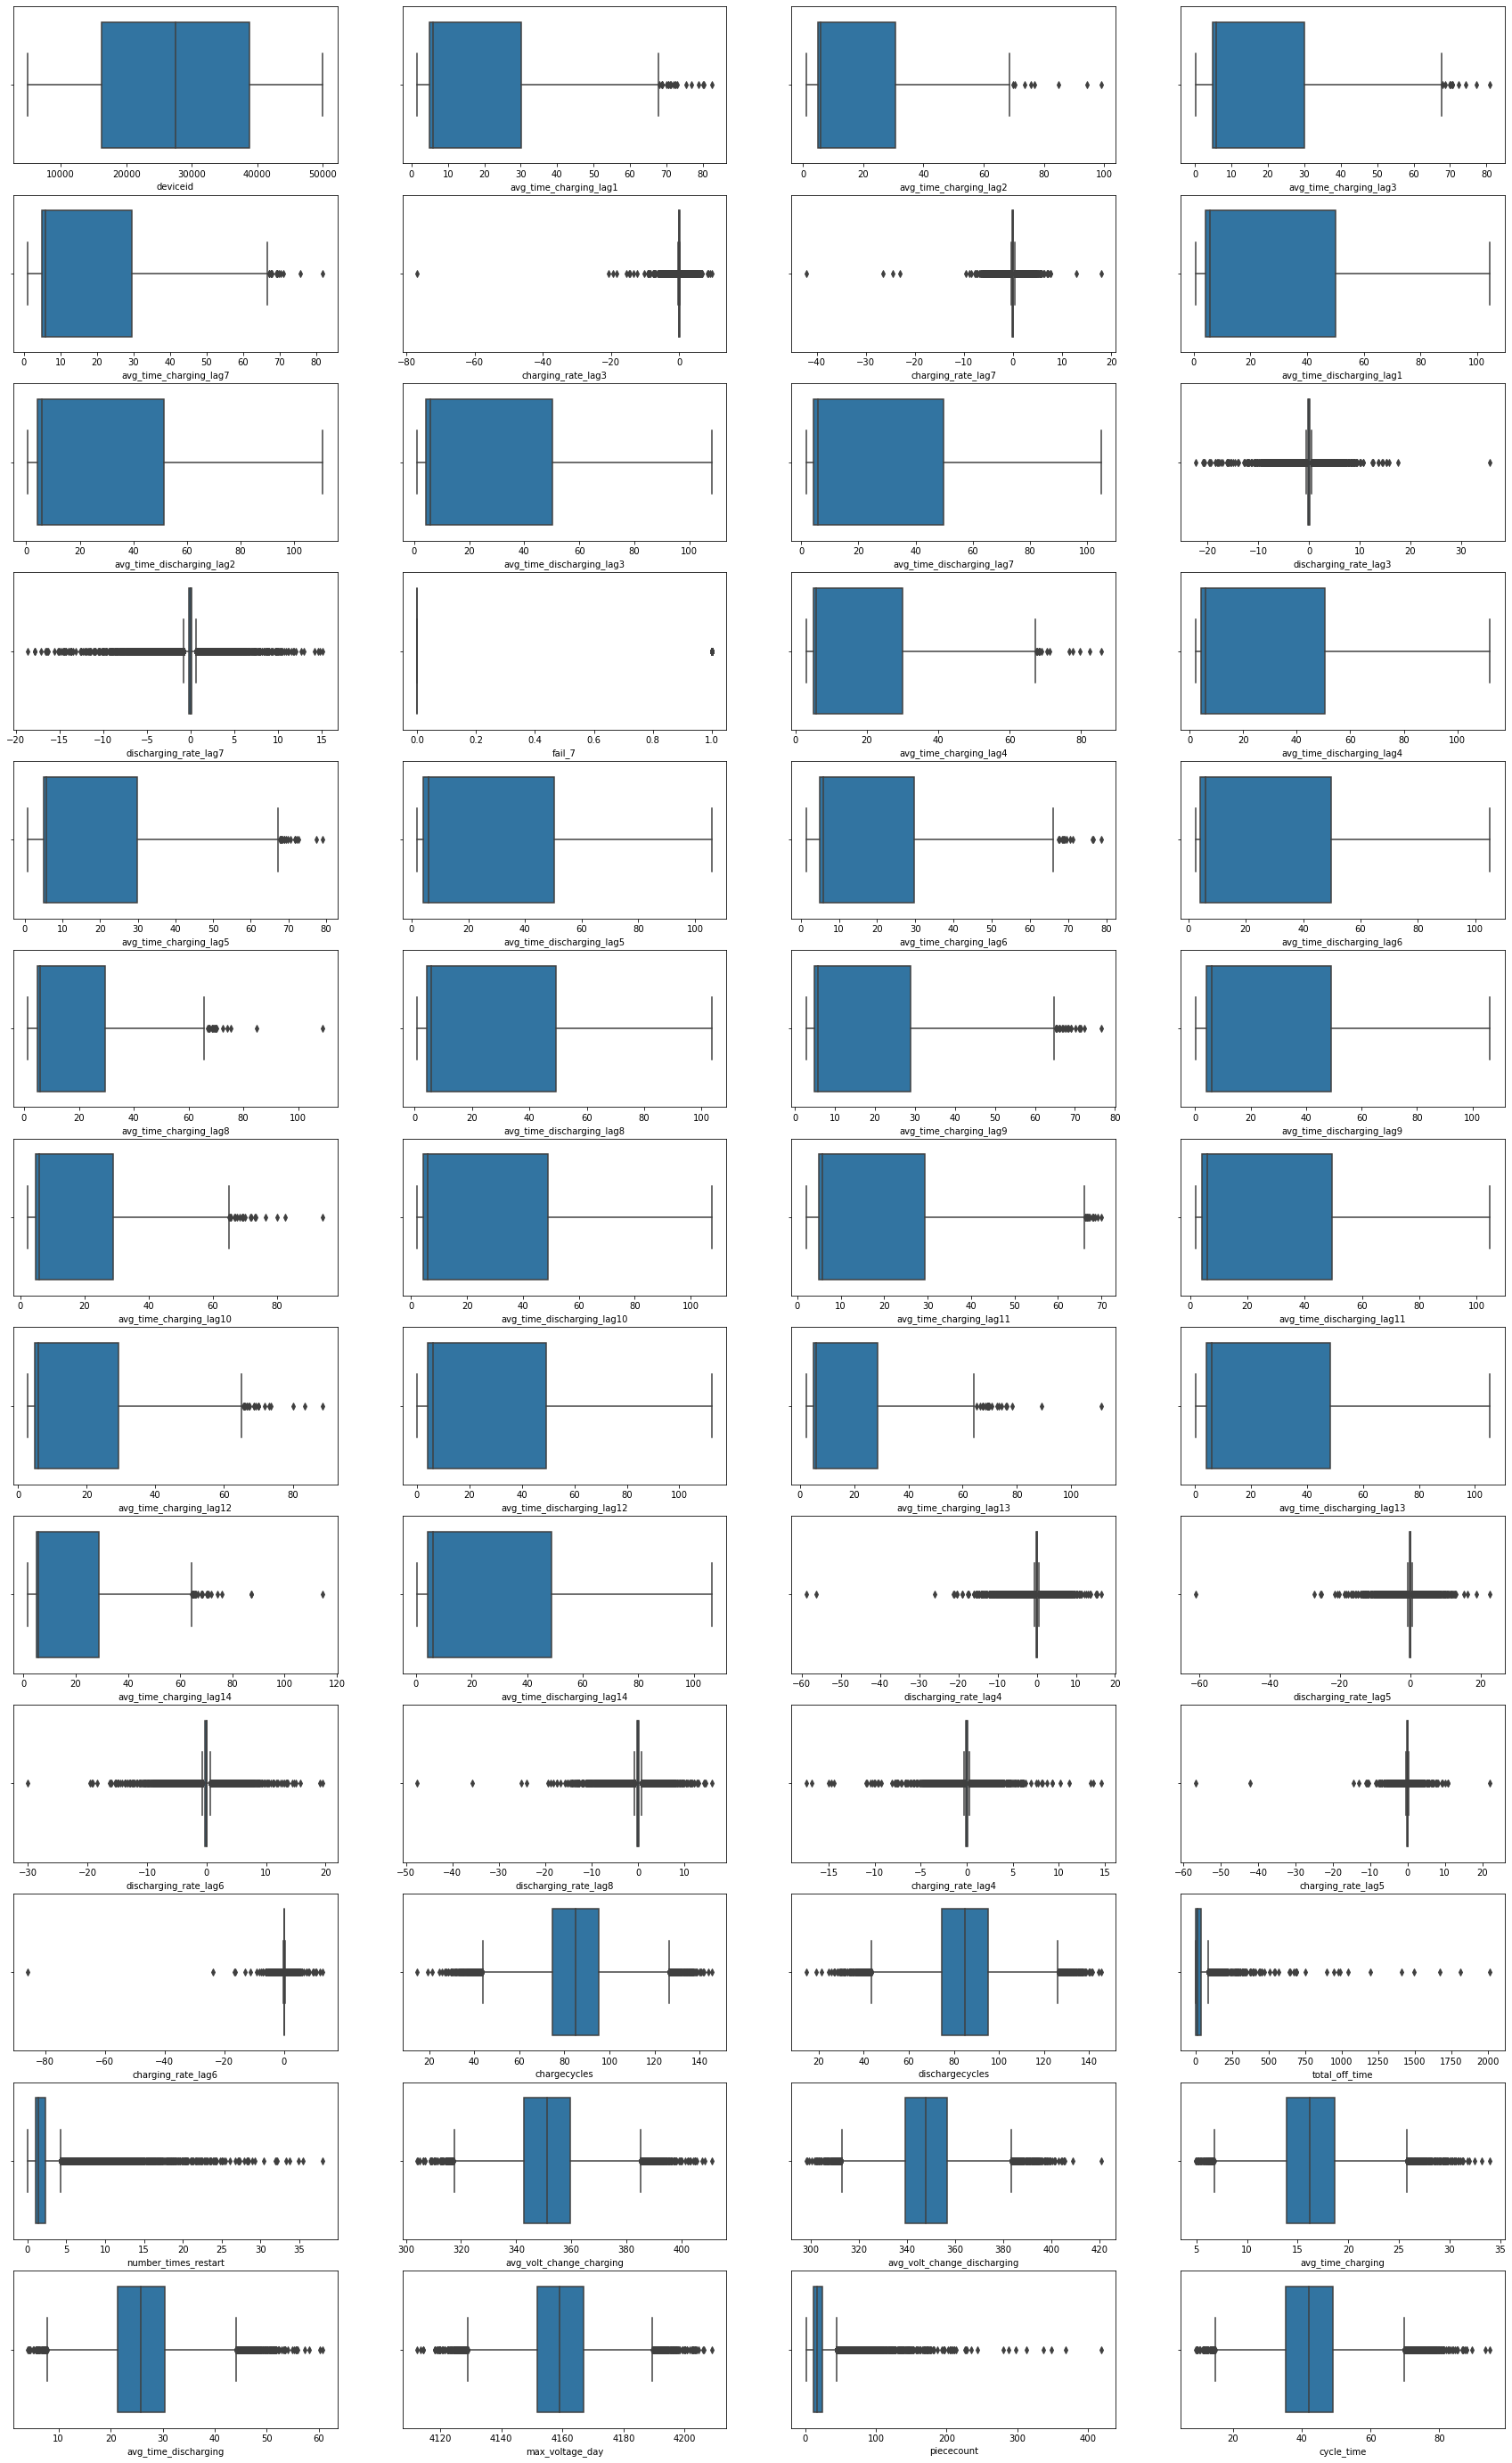

In [9]:
#create a function that creates a box plot for every numerical predictor variable
def box(df,colnames):
    
    f = plt.figure(figsize=(30,50))

    for i in range(len(colnames)):
        f.add_subplot(13, 4, i+1)
        sns.boxplot(x=df[colnames[i]])

    plt.show()

#save the column headers for the columns in the numeric_columns subset data frame
c = numeric_columns.columns

#call tthe box() function; create the boxplots graphs
box(numeric_columns,c)

<u>**Observations regarding the visualization of the data**</u>

1. For the most parts, the distribution of the features overlap each other with the exception of a select few. 

2. Speaking about the distributions, the majority of the features are positively skewed, meaning the that the mean is to the right of the median. The rest have a Gaussian distribution to some varying degree.

3. In a number of the features, it appears that a number of them have extreme outliers.

## Looking at the class distribution of the target variable (fail_7)

In [10]:
#what are the frequencies of each class?
#perform value_counts() on the fail_7 column
train.fail_7.value_counts()

0    31099
1     9401
Name: fail_7, dtype: int64

<AxesSubplot:xlabel='fail_7', ylabel='count'>

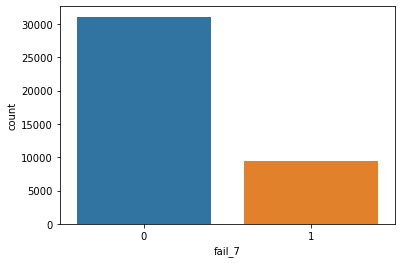

In [11]:
#visualize the frequency of each of the two classes (0 and 1)
sns.countplot(data=train, x='fail_7')

<u>**What does this mean?**</u>

Based on the value counts for the number of True and False rows, it seems that there are roughly **3.5 times** more rows that *False* vs the number of rows that are *True*. <br>

In other words, **the classes are imbalanced.** 

___

<center><h1> --- Cleaning the Data --- </h1></center> <br>

### Create MeterAge column

In [12]:
#convert LastRecord and Date Deployed columns to datetime64 objects
train.LastRecord = pd.to_datetime(train.LastRecord)
train['Date Deployed'] = pd.to_datetime(train['Date Deployed'])

<u>**Why did we convert the LastRecord and Date Deployed columns to datetime64 objects?**</u>

We converted these columns in order to perform calculations on them later; in order to do those calculations you have to convert these columns from object types to datetime64 types.

In [13]:
#Subtract difference between the dates in the LastRecord and Date Deployed columns
train['MeterAge'] = train['LastRecord'] - train['Date Deployed']

#convert the difference into weeks
train['MeterAge'] = train['MeterAge'] / np.timedelta64 (1, 'W')

#round the MeterAge column values, 2 places after decimal pt
train['MeterAge'] = round(train['MeterAge'],2)

#drop the LastRecord and Date Deployed columns
train = train.drop(['LastRecord', 'Date Deployed'], axis = 1)

<u>**Why did we create the MeterAge column?**</u>

The MeterAge column was created becase we concluded that you may be able to extract the information about the mailing meter unit's age if we subtract the date in the Date Deployed column from the date in the LastRecord column. <br>
        
*MeterAge(mailing meter unit's age) = LastRecord - Date Deployed*

<u>**Why did we drop the LastRecord and Date Deployed columns?**</u>

- Date Deployed = date when the meter was deployed
- LastRecord = 4/1/2021 = most recent check on the meters i.e data in the dataset is based on data collected that day

The *LastRecord* column was dropped since it only indicates when the data in our data set was recorded, just as the name implies. This means that it does not carry much, if any, significance as a predictor for training our models. <br>

The *Date Deployed* column was dropped since it only indicates the when the mailing meters were deployed - just as the column name implies. However, it seems that you may be able to extract another form of information based on the values in this column if combined with the information from another column such as the *LastRecord* column. <br>

    NOTE 
    This is why we created the MeterAge column. We took the LastRecord date and subtracted the Date Deployed column from it to extract the information that exists when combining the two columns which is the mailing meter unit's age.


## Dropping and formatting columns

In [14]:
#remove deviceid column
train = train.drop('deviceid',1)

#shape after dropping the deviceid column
train.shape

(40500, 53)

<u>**Why did we drop the deviceid column?**</u> 

The values in the **deviceid** column simply represent the identifier codes for the mailing meter units recorded in the data set. Therefore, we can the drop the column since it will not provide any substantial information other than to let us know what the identifier codes are on the mailing meter units.

In [15]:
#convert fail_7 column values to bool
train['fail_7'] = train['fail_7'].astype(bool)

<u>**Why did we convert the fail_7 column values from numeric to bool?** </u>

We converted the values to bool because **fail_7** is a column with binary values that indicates whether a mailing meter unit will fail in the next 7 days. <br>
- **0** denotes the mailing meter unit won't fail in the next 7 days
- **1** denotes that the mailing meter unit will fail in the next 7 days.

## Handling missing data

### Detect missing values

In [16]:
#calculate the percentage of missing values in every column
#sort in descending order; see column(s) with the most missing data at the top
percentage_missing_vals =train.isnull().sum()  * 100/ len(train)
percentage_missing_vals.sort_values(ascending = False)

avg_time_discharging_lag14     16.464198
avg_time_charging_lag14        16.464198
avg_time_discharging_lag13     10.819753
avg_time_charging_lag13        10.819753
avg_time_discharging_lag12      6.807407
avg_time_charging_lag12         6.807407
avg_time_charging_lag11         3.916049
avg_time_discharging_lag11      3.916049
avg_time_discharging_lag10      1.967901
avg_time_charging_lag10         1.967901
avg_time_discharging_lag9       0.923457
avg_time_charging_lag9          0.923457
avg_time_charging_lag8          0.400000
avg_time_discharging_lag8       0.400000
avg_time_charging_lag7          0.162963
avg_time_discharging_lag7       0.162963
discharging_rate_lag8           0.076543
avg_time_discharging_lag6       0.069136
avg_time_charging_lag6          0.069136
discharging_rate_lag7           0.029630
charging_rate_lag7              0.029630
avg_time_discharging_lag5       0.017284
avg_time_charging_lag5          0.017284
charging_rate_lag6              0.004938
discharging_rate

<u>**Observations made from the table above** </u>

1. Most of the missing data can be found in the columns that indicate the charging/discharging rates where (lag day > 5). Meaning that the further away the date is from the date when the data for the meter was last recorded, the higher the chance that you would find missing data.

2. There aren't any missing values in either of the binary/boolean columns (**charge_cycle_time_below_12** and **fail_7**).

### Creating missing-value-indicator columns for columns with missing values

In [17]:
#identify all the columns with missing values
#create a list of the names of the columns with missing values
columns_with_nulls = train.columns[train.isnull().any()].tolist()

#how many columns with missing values are there?
#len(columns_with_nulls)

#create a subset data frame
#data frame contains the columns with missing values
df_of_missing = train[columns_with_nulls]

#double-check the shape of the data frame to make sure that there are 25 columns
#df_of_missing.shape <- should output 25 

#create a data frame by concatenating the columns with missing values and their respective missing value indicator column
#add _NA at the end of every column name to denote that the column is an indicator column
indicators_for_df_of_missing = pd.concat([df_of_missing, df_of_missing.isnull().astype(bool).add_suffix('_NAs')], axis=1)

#sort columns in descending order
#store the df to a shorter, much more legible variable name
missing_ind_df = indicators_for_df_of_missing.sort_index(axis = 1, ascending = False)

#drop the columns in the columns_with_nulls list;
#keep the missing values indicator columns in the dataframe
missing_ind_df = missing_ind_df.drop(columns_with_nulls, axis = 1)

<u>**Why did we include "missing-value-indicator" columns?**</u>

We decided to apply *missing-value-indicators* on top of utilizating a KNN-based imputer to fill in the missing values just in case that there is valuable information to be extracted behind whether a value in a certain column in missing or not. <br>

In the event that the missing values did not occur by chance, we wanted a way to express that information and include it in the data set.

### Imputing missing values

In [18]:
#instantiate KNNImputer
#set the n_neighbors = 5; impute the value of the missing record by using its 5 nearest neighbors as reference
#include add_indicator = True; indicate missing values
knn_imputer = KNNImputer(n_neighbors = 5)

#perform imputation using KNNImputer w/ nearest neighbor = 5 
imputer_on_train = knn_imputer.fit_transform(train)

In [19]:
#print the array output
print(imputer_on_train)

[[ 5.12       41.11        6.56       ... 14.2        60.70125
  77.57      ]
 [36.6         5.16        6.23       ... 19.77777778 52.09714286
  74.57      ]
 [ 5.51        5.04        4.52       ... 19.2        34.14666667
  74.        ]
 ...
 [ 4.73        4.77        5.71       ... 26.4        47.63818182
  75.86      ]
 [ 4.93        5.01        4.85       ... 17.71428571 37.451
  78.14      ]
 [30.83        5.18       33.17       ... 30.85714286 55.96909091
  80.43      ]]


<u>**Why KNNImputer instead of other imputation methods/techniques?**</u>

Although there are other means of imputation such as:
- simple imputers based on mean, median, and mode
- iterativeimputer which creates a regression model based on the other features to predict the missing values

Since we have a fairly large data set with roughly 40,000+ rows and 50+ columns, we thought that using a multivariate imputer would yield imputed values that are more representative of the data set. <br>

We did not use the IterativeImputer from scikit-learn's impute module because it is still an experimental feature. --maybe a more mathematic explanation?--

In [20]:
#convert the numpy array version of the 'train' data frame outputted by the imputation back to a dataframe
post_impute_train= pd.DataFrame(imputer_on_train, columns = train.columns)

#check to see that the imputation was done properly
#train_imputed.head() and compare with train.head(); 
#check if values are the same across the columns for every row in both df

#post_impute_train.head()
#train.head()

In [21]:
#convert charge_cycle_time_below_12 column values to bool
post_impute_train['charge_cycle_time_below_12'] = post_impute_train['charge_cycle_time_below_12'].astype(bool)

#convert fail_7 column values to bool
post_impute_train['fail_7'] = post_impute_train['fail_7'].astype(bool)

<u>**Why are we converting the charge_cycle_time_below_12 and fail_7 column values to boolean again? Weren't they already boolean?**</u>

The values in both columns were initially boolean, prior to performing the imputation. It seems like the values in these columns were converted into int64 dtype after performing the imputation on the entire 'train' data frame. Therefore, we are basically reverting the values in these columns back to boolean.

### Creating the 'clean' data frame

In [22]:
"""
    Remember that: 
    
    missing_ind_df is the data frame that contains the missing-values-indicator columns for the columns in the train data frame
    that has missing values.
    
"""
#concatenate the post_impute_train data frame and the missing_ind_df data frame horizontally
train_imputed = pd.concat([post_impute_train, missing_ind_df], axis = 1)

In [23]:
#inspect the data frame we just created
train_imputed.head()

#can compare with train.head() to see if the rows match up -- for doublechecking

avg_time_charging_lag1  avg_time_charging_lag2  avg_time_charging_lag3  \
0                    5.12                   41.11                    6.56   
1                   36.60                    5.16                    6.23   
2                    5.51                    5.04                    4.52   
3                    4.66                   39.85                   35.76   
4                    5.10                   43.24                    4.63   

   avg_time_charging_lag7  charging_rate_lag3  charging_rate_lag7  \
0                   25.39            0.086667           -0.006667   
1                    6.96            0.136667           -1.296667   
2                    5.96           -0.460000           -0.083333   
3                   40.69            0.076667           -0.006667   
4                    5.26            0.040000           -0.153333   

   avg_time_discharging_lag1  avg_time_discharging_lag2  \
0                       4.37                      91.70   
1                      62.67                       6.53   
2                       5.13                       5.65   
3                       3.93                      76.37   
4                       4.69                      71.44   

   avg_time_discharging_lag3  avg_time_discharging_lag7  \
0                      15.70                      39.12   
1                       6.16                       8.25   
2                       4.14                      14.02   
3                      60.86                      73.53   
4                       3.80                       6.29   

   discharging_rate_lag3  discharging_rate_lag7  fail_7  \
0              -1.163333               0.033333   False   
1              -0.066667              -2.653333   False   
2              -2.643333               0.686667   False   
3              -0.166667               0.033333   False   
4               0.066667              -1.030000   False   

   charge_cycle_time_below_12  avg_time_charging_lag4  \
0                       False                    4.99   
1                       False                   13.64   
2                       False                   25.01   
3                       False                    4.71   
4                        True                   40.36   

   avg_time_discharging_lag4  avg_time_charging_lag5  \
0                       5.85                   24.35   
1                      20.37                    5.65   
2                      40.69                    6.03   
3                       3.74                    4.74   
4                      82.70                   15.47   

   avg_time_discharging_lag5  avg_time_charging_lag6  \
0                      31.02                   43.42   
1                       4.77                   19.41   
2                       6.06                    5.72   
3                       3.73                   24.01   
4                      24.21                   45.64   

   avg_time_discharging_lag6  avg_time_charging_lag8  \
0                      79.33                  18.386   
1                      24.33                  35.920   
2                       5.73                  22.460   
3                      52.99                   5.090   
4                      76.42                  26.630   

   avg_time_discharging_lag8  avg_time_charging_lag9  \
0                     26.956                   4.848   
1                     59.380                   4.490   
2                     31.820                  33.920   
3                      5.320                   4.450   
4                     45.040                  27.990   

   avg_time_discharging_lag9  avg_time_charging_lag10  \
0                      5.346                   18.502   
1                      4.120                   44.180   
2                     58.870                   45.870   
3                      4.220                   22.140   
4                     40.570                    5.010   

   avg_time_discharging_la

<center><h3> <span style="color:red"> ***Before moving on to the next section, remember that...*** </span></h3></center><br>


<center><h4>the 'train' data set will be referred to as the variable name <span style="color:green">train_imputed</span> after this point</h4></center>
    
    
    
<center><h4><span style="color:green">train_imputed</span> is, as the name implies, the 'cleaned' data frame after handling the missing values</h4></center>


___

<center><h1>--- Feature Extraction ---</h1></center> <br>

## Create avg_cycle_time_lag[ i ] columns

In [24]:
#create avg_cycletime_lag[i] columns, where i is the lag day
train_imputed['avg_cycletime_lag1'] = train_imputed['avg_time_charging_lag1']+ train_imputed['avg_time_discharging_lag1']
train_imputed['avg_cycletime_lag2'] = train_imputed['avg_time_charging_lag2']+ train_imputed['avg_time_discharging_lag2']
train_imputed['avg_cycletime_lag3'] = train_imputed['avg_time_charging_lag3']+ train_imputed['avg_time_discharging_lag3']
train_imputed['avg_cycletime_lag4'] = train_imputed['avg_time_charging_lag4']+ train_imputed['avg_time_discharging_lag4']
train_imputed['avg_cycletime_lag5'] = train_imputed['avg_time_charging_lag5']+ train_imputed['avg_time_discharging_lag5']
train_imputed['avg_cycletime_lag6'] = train_imputed['avg_time_charging_lag6']+ train_imputed['avg_time_discharging_lag6']
train_imputed['avg_cycletime_lag7'] = train_imputed['avg_time_charging_lag7']+ train_imputed['avg_time_discharging_lag7']
train_imputed['avg_cycletime_lag8'] = train_imputed['avg_time_charging_lag8']+ train_imputed['avg_time_discharging_lag8']
train_imputed['avg_cycletime_lag9'] = train_imputed['avg_time_charging_lag9']+ train_imputed['avg_time_discharging_lag9']
train_imputed['avg_cycletime_lag10'] = train_imputed['avg_time_charging_lag10']+ train_imputed['avg_time_discharging_lag10']
train_imputed['avg_cycletime_lag11'] = train_imputed['avg_time_charging_lag11']+ train_imputed['avg_time_discharging_lag11']
train_imputed['avg_cycletime_lag12'] = train_imputed['avg_time_charging_lag12']+ train_imputed['avg_time_discharging_lag12']
train_imputed['avg_cycletime_lag13'] = train_imputed['avg_time_charging_lag13']+ train_imputed['avg_time_discharging_lag13']
train_imputed['avg_cycletime_lag14'] = train_imputed['avg_time_charging_lag14']+ train_imputed['avg_time_discharging_lag14']

#create a list of the columns that were used to create the avg_cycletime_lag[i] columns
redundant_time_dANDcharging= ['avg_time_charging_lag1','avg_time_discharging_lag1','avg_time_charging_lag2','avg_time_discharging_lag2','avg_time_charging_lag3','avg_time_discharging_lag3',
             'avg_time_charging_lag4','avg_time_discharging_lag4','avg_time_charging_lag5','avg_time_discharging_lag5','avg_time_charging_lag6','avg_time_discharging_lag6',
             'avg_time_charging_lag7','avg_time_discharging_lag7','avg_time_charging_lag8','avg_time_discharging_lag8','avg_time_charging_lag9','avg_time_discharging_lag9',
             'avg_time_charging_lag10','avg_time_discharging_lag10','avg_time_charging_lag11','avg_time_discharging_lag11','avg_time_charging_lag12',
             'avg_time_discharging_lag12','avg_time_charging_lag13','avg_time_discharging_lag13','avg_time_charging_lag14','avg_time_discharging_lag14']

#drop the columns within the list created above
train_imputed.drop(redundant_time_dANDcharging, inplace=True, axis=1)           

<u>**Why did we create the avg_cycle_time_lag[i] columns?** </u>

As indicated in the Variables.docx file (the .docx provided to us which provides context as to what each variable column is and what their respective values represent): <br>

   *cycle_time = charging + discharging time*

We applied the concept above to the *avg_time_charging_lag[i]* and *avg_time_discharging_lag[i]* to *create the avg_cycle_time_lag[i]* column, where [i] is the corresponding lag day.<br>

   *avg_cycle_time_lag = avg_time_charging_lag[i] + avg_time_discharging_lag[i]*
   
<u>**Why did we drop the columns in the redundant_time_dANDcharging list?**</u>

We dropped them since it would be redundant to have those columns in our data set after we created the *avg_cycle_time_lag[i]* columns. <br>

In addition to that, since the information in the *avg_cycle_time_lag[i]* column is derived from the *avg_time_charging_lag[i]* and *avg_time_discharging_lag[i]* columns, leaving those said columns in might introduce highly collinear relationships between the predictors/columns. <br>

We created the *avg_cycle_time_lag[i]* columns to consolidate the information that is provided in the *avg_time_charging_lag[i]* and *avg_time_discharging_lag[i]* columns.

## Create netcharge_rate_lag[ i ] columns

In [25]:
#create netcharge_rate_lag[i] columns, where i is the lag day
train_imputed['netcharge_rate_lag3'] = train_imputed['charging_rate_lag3']+ train_imputed['discharging_rate_lag3']
train_imputed['netcharge_rate_lag4'] = train_imputed['charging_rate_lag4']+ train_imputed['discharging_rate_lag4']
train_imputed['netcharge_rate_lag5'] = train_imputed['charging_rate_lag5']+ train_imputed['discharging_rate_lag5']
train_imputed['netcharge_rate_lag6'] = train_imputed['charging_rate_lag6']+ train_imputed['discharging_rate_lag6']
train_imputed['netcharge_rate_lag7'] = train_imputed['charging_rate_lag7']+ train_imputed['discharging_rate_lag7']
train_imputed['netcharge_rate_lag8'] = train_imputed['discharging_rate_lag8'] * -1

#create a list of the columns that were used to create the netcharge_rate_lag[i] columns
redundant_dANDcharge_rate = ['charging_rate_lag3','discharging_rate_lag3','charging_rate_lag4','discharging_rate_lag4',
                    'charging_rate_lag5','discharging_rate_lag5','charging_rate_lag6','discharging_rate_lag6',
                    'charging_rate_lag7','discharging_rate_lag7','discharging_rate_lag8']

#drop the columns within the list created above
train_imputed.drop(redundant_dANDcharge_rate, inplace = True, axis = 1)

<u>**Why did we create the netcharge_rate_lag[i] columns?**</u>

We created the *netcharge_rate_lag[i]* columns under the logic that: <br>

*charging_rate* - *discharging_rate* = *net_charge*

In addition to that, we also operated under the logic that discharge values are inherently negative when compared to charge values therefore: <br>

We subtracted *discharging_rate_lag[i]* from *charging_rate_lag[i]* to get the net charge rate of lag day *i*. We expressed the net charge as a rate since the discharging and charging values are also expressed in terms of rates. <br>

The isolated case would have to be *discharge_rate_lag8*. We inferred that if the *charging_rate_lag8* column is not missing due to an error when importing the data from the mailing meter units, then it might be missing due some factors, one of which could be: <br>

- the data set was recorded during a period of the day when the mailing meter units are not charging (assuming that there are "general charging" and/or "general discharging" periods and that mailing meter units don't charge while in use).

With that said, in order to abide by the concept of discharge values being inherently negative, we decided to multiply the *discharge_rate_lag8* by -1. Not only that, but we opted to do since the would-be corresponding column *charging_rate_lag8* column is missing. Thus, we would not have a charging rate column to subtract *discharge_rate_lag8* from.

<u>**Why did we drop the columns in the redundant_dANDcharge_rate list?**</u>

We are dropping the columns within the *redundant_dANDcharge_rate* list since we consolidated the information from these columns into the *netcharge_rate_lag[i]* columns that we created. Another reason we are dropping these columns is because keeping the columns in the data set would be akin to leaving redundant columns in the data frame.  <br>

## Create avg_cycletime column

In [26]:
#create the avg_cycletime column
train_imputed['avg_cycletime'] = train_imputed['avg_time_charging'] + train_imputed['avg_time_discharging']

#create a list of the columns used to create the avg_cycletime column
redundant_dANDcharging_time = ['avg_time_charging','avg_time_discharging']

#drop the columns within the list created above
train_imputed.drop(redundant_dANDcharging_time, inplace = True, axis =1)

<u>**Why did we create the avg_cycletime column?**</u>

We created the *avg_cycletime* column under the same principle/logic that: <br>

*cycle_time = charging + discharging time* <br>

If we extend and apply that concept to *avg_time_charging* and *avg_time_discharging*, we would get: <br>

*avg_cycle_time* = *avg_time_charging* + *avg_time_discharging*

<u>**Why did we drop the columns in the redundant_dANDcharging_time list?**</u>

We dropped the columns in the *redundant_dANDcharging_time* list since we've already consolidated the information from these columns(*avg_time_charging* + *avg_time_discharging*) into the *avg_cycle_time* column we created. And yet again, leaving the columns - the columns that are inside the list of dropped columns - would be just leaving redundant data in the data set.

___

<center><h1> --- Feature Selection --- </h1></center> <br>


## Creating subsets; predictor matrix and target vector

In [27]:
#create a subset dataframe consisting of just the feature matrix -- drop fail_7 and keep everything else
X = train_imputed.drop('fail_7',1)

#create a subset dataframe/vector of just the target variable, which is fail_7
y = train_imputed.fail_7

In [28]:
#check the shapes of each subset
X.shape, y.shape

((40500, 57), (40500,))

## Looking at the correlation levels

### Correlation between ALL predictor variables

<AxesSubplot:>

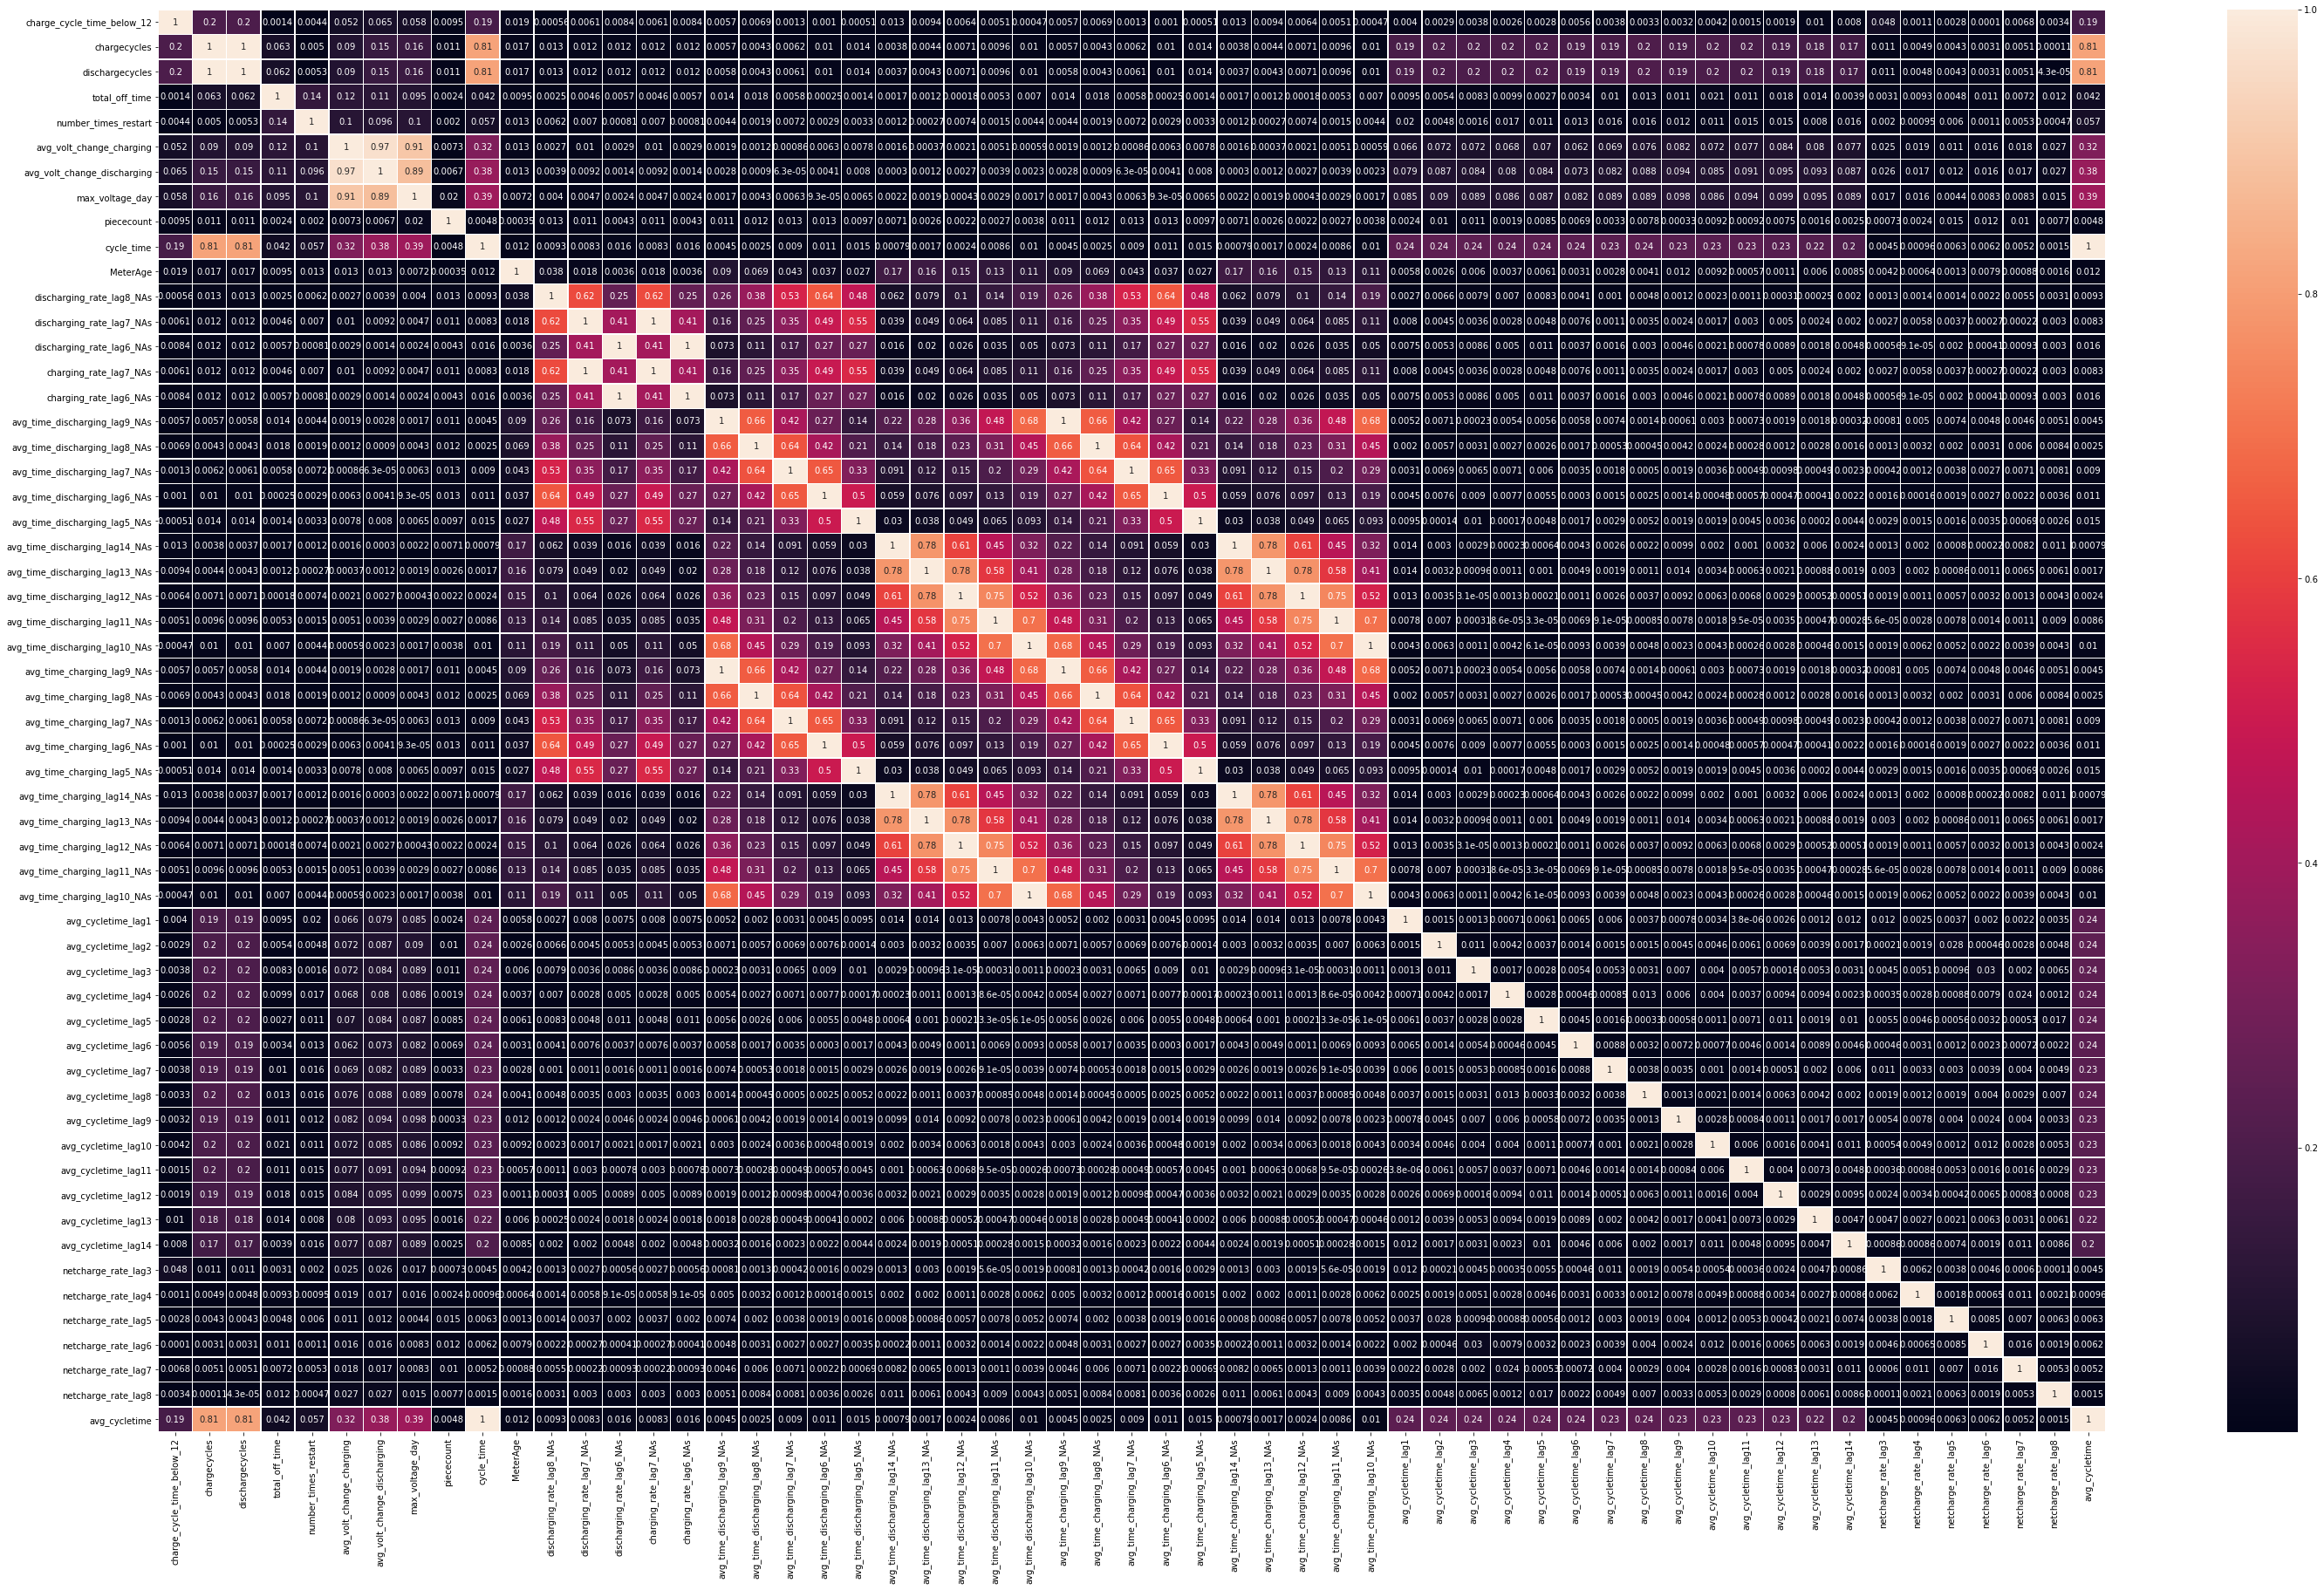

In [29]:
#correlation matrix between predictors 
xcorr = X.corr().abs()

#create a heatmap illustrating the correlation between ALL variables
fig, ax = plt.subplots(figsize=(50,30)) 
sns.heatmap(xcorr, annot=True, linewidths=.5, ax=ax)

### Correlation between predictors vs. target

In [30]:
#create a series that contains the correlation coefficients between the predictor variable and the target variable
xVSyCorr = X.corrwith(y) #

#create a dataframe out of the series object - xVSyCorr
ycorr = pd.DataFrame(xVSyCorr, columns=['correlation'])

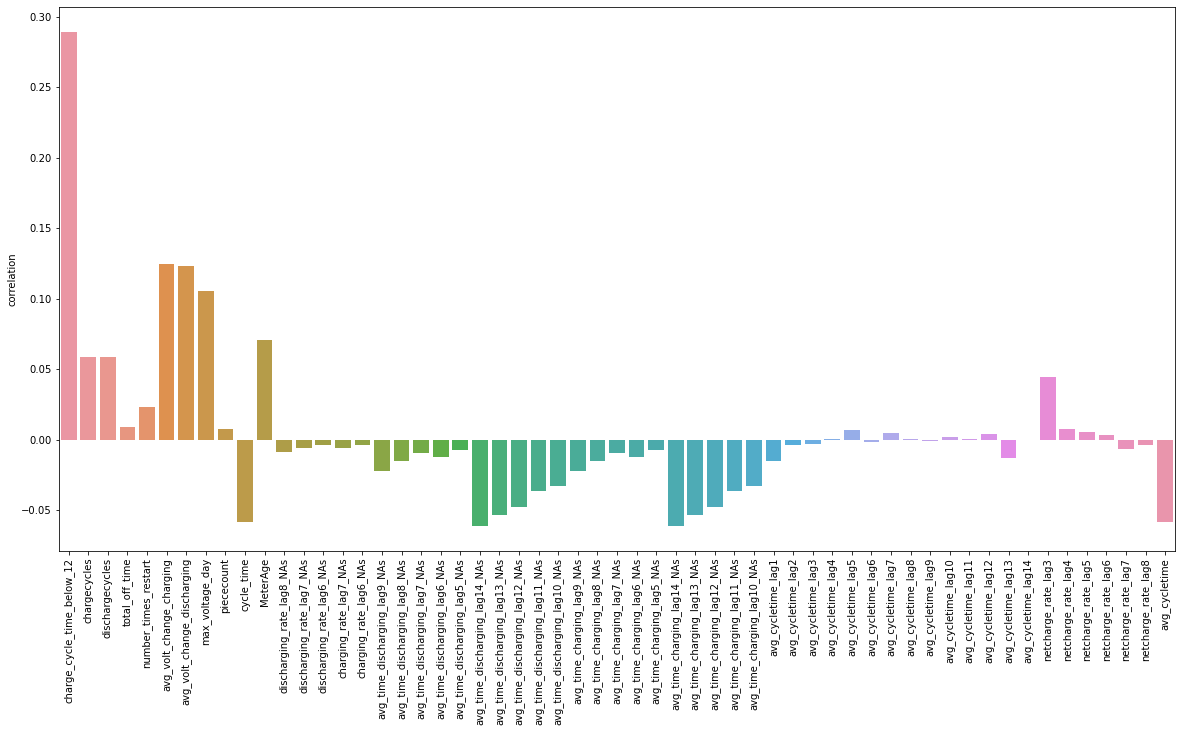

In [31]:
#create barplot;
#illustrate the correlation coefficient between the 25 features that have the highest correlation with the target and the target
plt.figure(figsize=(20,10)) 
sns.barplot(data=ycorr, x=ycorr.index, y='correlation')
plt.xticks(rotation=90); ## <- add the ";" to prevent matplotlib+sns from printing out the labels while rendering the graph

## Taking a look under the hood -- feature selection using variance

### What is variance?

1. "*Unlike range and quartiles, variance combines all the values in a data set to produce a measure of spread. The variance (symbolized by **S** <sup>2</sup> and standard deviation (the square root of the variance, symbolized by **S**) are the most commonly used measures of spread.*

    *We know that variance is a measure of how spread out a data set is. It is calculated as the average squared deviation of each number from the mean of a data set. For example, for the numbers 1, 2, and 3 the mean is 2 and the variance is 0.667.*

    *[(1 - 2)<sup>2</sup> + (2 - 2)<sup>2</sup> + (3 - 2)<sup>2</sup>] ÷ 3 = 0.667*

    *[squaring deviation from the mean] ÷ number of observations = variance*

    *Variance (**S<sup>2</sup>**) = average squared deviation of values from mean*

    *Calculating variance involves squaring deviations, so it does not have the same unit of measurement as the original observations. For example, lengths measured in metres (**m**) have a variance measured in metres squared (**m<sup>2</sup>**).*

    *Taking the square root of the variance gives us the units used in the original scale and this is the standard deviation.* " -- [[1]](https://www150.statcan.gc.ca/n1/edu/power-pouvoir/ch12/5214891-eng.htm#:~:text=We%20know%20that%20variance%20is,and%20the%20variance%20is%200.667.)

### How does VarianceThreshold work?

1. "Feature selector that removes all low-variance features.This feature selection algorithm looks only at the features (X), not the desired outputs (y), and can thus be used for unsupervised learning." [[1]](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) <br>


2. "*If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed*.<br>

    *Or if only a handful of observations differ from a constant value, the variance will also be very low.*<br>
    
    *[In a situation], where a feature has been poorly evaluated, or brings little information because it is (almost) constant -- that can be a justification to remove a column.*<br>

    *Otherwise, you have to set an arbitrarily variance threshold to determine which features [to remove] And, using the accuracy of the predictions as a result of a feature removal to prove that justification for feature removal is correct. Basically, its a trial and error.*<br>

    *The variance threshold calculation depends on the probability density function of a particular distribution. For example if a feature has a normal distribution, use normal variance.*<br>

    *Variance threshold for feature selection:*

    - *low variance features contains less information*
    - *calculate variance of each feature, then drop features with variance below some threshold* "
    [[2]](https://community.dataquest.io/t/feature-selection-features-with-low-variance/2418)

### Select the best features -- using low-variance remover filter

In [32]:
#instantiate VarianceThreshold
#set threshold parameter = [.0 to 0.3] <--- play around with this number and see which value cuts down the # of features in half
var_threshold = VarianceThreshold(threshold = 0.1)

#run variance threshold
data_transformed = var_threshold.fit_transform(X)

In [33]:
#view outputs after applying the filter
var_threshold.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [34]:
#create a list via list comprehension
#the list contains the columns from the feature matrix that were below the specified variance threshold
low_variance_features = [column for column in X.columns
                   if column not in X.columns[var_threshold.get_support()]]

#print the columns that were below the specified threshold; columns to be removed after applying the threshold filter
print((low_variance_features))

['discharging_rate_lag8_NAs', 'discharging_rate_lag7_NAs', 'discharging_rate_lag6_NAs', 'charging_rate_lag7_NAs', 'charging_rate_lag6_NAs', 'avg_time_discharging_lag9_NAs', 'avg_time_discharging_lag8_NAs', 'avg_time_discharging_lag7_NAs', 'avg_time_discharging_lag6_NAs', 'avg_time_discharging_lag5_NAs', 'avg_time_discharging_lag13_NAs', 'avg_time_discharging_lag12_NAs', 'avg_time_discharging_lag11_NAs', 'avg_time_discharging_lag10_NAs', 'avg_time_charging_lag9_NAs', 'avg_time_charging_lag8_NAs', 'avg_time_charging_lag7_NAs', 'avg_time_charging_lag6_NAs', 'avg_time_charging_lag5_NAs', 'avg_time_charging_lag13_NAs', 'avg_time_charging_lag12_NAs', 'avg_time_charging_lag11_NAs', 'avg_time_charging_lag10_NAs']


In [35]:
#print a count of the number of features below the specified threshold
print(len(low_variance_features))

23


In [36]:
#create a subset data frame that contains all columns that were ABOVE the variance threshold
data_transformed = X.loc[:, var_threshold.get_support()]

#view the column headers of the data_transformed dataframe
#you can look at exactly which features were above the variance threshold
data_transformed.columns

Index(['charge_cycle_time_below_12', 'chargecycles', 'dischargecycles',
       'total_off_time', 'number_times_restart', 'avg_volt_change_charging',
       'avg_volt_change_discharging', 'max_voltage_day', 'piececount',
       'cycle_time', 'MeterAge', 'avg_time_discharging_lag14_NAs',
       'avg_time_charging_lag14_NAs', 'avg_cycletime_lag1',
       'avg_cycletime_lag2', 'avg_cycletime_lag3', 'avg_cycletime_lag4',
       'avg_cycletime_lag5', 'avg_cycletime_lag6', 'avg_cycletime_lag7',
       'avg_cycletime_lag8', 'avg_cycletime_lag9', 'avg_cycletime_lag10',
       'avg_cycletime_lag11', 'avg_cycletime_lag12', 'avg_cycletime_lag13',
       'avg_cycletime_lag14', 'netcharge_rate_lag3', 'netcharge_rate_lag4',
       'netcharge_rate_lag5', 'netcharge_rate_lag6', 'netcharge_rate_lag7',
       'netcharge_rate_lag8', 'avg_cycletime'],
      dtype='object')

In [37]:
#view the head of the subset
data_transformed.head()

charge_cycle_time_below_12  chargecycles  dischargecycles  total_off_time  \
0                       False     50.250000        49.750000       49.000000   
1                       False     56.285714        56.000000       36.857143   
2                       False     80.380952        80.333333        2.333333   
3                       False     91.736842        91.684211       10.789474   
4                        True     71.066667        70.733333       14.266667   

   number_times_restart  avg_volt_change_charging  \
0              2.375000                377.080000   
1              1.000000                350.517857   
2              4.095238                346.113333   
3              0.736842                356.184211   
4              1.133333                370.904000   

   avg_volt_change_discharging  max_voltage_day  piececount  cycle_time  \
0                   367.428750      4174.875000   14.200000   60.701250   
1                   350.309286      4161.000000   19.777778   52.097143   
2                   343.409524      4152.238095   19.200000   34.146667   
3                   349.844737      4164.631579   23.625000   42.496316   
4                   367.730000      4169.800000   12.666667   49.609333   

   MeterAge  avg_time_discharging_lag14_NAs  avg_time_charging_lag14_NAs  \
0     77.57                            True                         True   
1     74.57                            True                         True   
2     74.00                           False                        False   
3     78.29                           False                        False   
4     80.86                           False                        False   

   avg_cycletime_lag1  avg_cycletime_lag2  avg_cycletime_lag3  \
0                9.49              132.81               22.26   
1               99.27               11.69               12.39   
2               10.64               10.69                8.66   
3                8.59              116.22               96.62   
4                9.79              114.68                8.43   

   avg_cycletime_lag4  avg_cycletime_lag5  avg_cycletime_lag6  \
0               10.84               55.37              122.75   
1               34.01               10.42               43.74   
2               65.70               12.09               11.45   
3                8.45                8.47               77.00   
4              123.06               39.68              122.06   

   avg_cycletime_lag7  avg_cycletime_lag8  avg_cycletime_lag9  \
0               64.51              45.342              10.194   
1               15.21              95.300               8.610   
2               19.98              54.280              92.790   
3              114.22              10.410               8.670   
4               11.55              71.670              68.560   

   avg_cycletime_lag10  avg_cycletime_lag11  avg_cycletime_lag12  \
0                49.57               50.494                53.62   
1               116.64               76.470                29.82   
2               122.23               12.010                 9.50   
3                52.65                8.540                 8.53   
4                11.53               10.110                10.44   

   avg_cycletime_lag13  avg_cycletime_lag14  netcharge_rate_lag3  \
0               76.648               65.480            -1.076667   
1               57.290               45.548             0.070000   
2                8.230               68.080            -3.103333   
3               31.890                9.130            -0.090000   
4               72.860               58.910             0.106667   

   netcharge_rate_lag4  netcharge_rate_lag5  netcharge_rate_lag6  \
0            -0.430000            -0.030000             0.650000   
1            -4.376667             0.450000            -4.073333   
2            -0.076667             0.240000            -0.013333   
3            -0.016667          

In [38]:
#take a look at the shape of the data
data_transformed.shape

(40500, 34)

### Why take this approach?

Feature selection based on variance is a baseline method. It helps reduce the number of predictor variables that we have to work with by eliminating the features with low variance. And just to reiterate, features with low -or close to zero- variance are almost constant and thus will not improve the performance of our model. This is why we would remove those low, or no, variance features.

## Selecting the *k* number of best features -- use mutual_info_classif score as the metric

*k* is the number of features that you want to keep. SelectKBest selects the top *k* number of features after running the feature selection method on our training data. <br>

In our case, we are opting to select the **top 10 features** based on the mutual information score/ information gain. 

In [39]:
#Instantiate SelectKBest
#Set k = 10; select top 10 best features based on mutual information score
select_kbestMUTINF = SelectKBest(mutual_info_classif, k = 10)

In [40]:
#perform feature selection with SelectKBest using mutual information score as the measure
bestft_MUTINF = select_kbestMUTINF.fit(data_transformed,y)

In [41]:
#output all the best k number of features using mutual info classification
bestft_MUTINF_cols = data_transformed.columns[bestft_MUTINF.get_support()]
print(bestft_MUTINF_cols)

Index(['charge_cycle_time_below_12', 'chargecycles', 'total_off_time',
       'number_times_restart', 'avg_volt_change_charging',
       'avg_volt_change_discharging', 'max_voltage_day',
       'avg_time_charging_lag14_NAs', 'netcharge_rate_lag3',
       'netcharge_rate_lag5'],
      dtype='object')


In [42]:
#data_transformed_MUTINF = X.loc[:, var_threshold.get_support()]
bestft_MUTINF_cols_df = data_transformed.loc[:,bestft_MUTINF.get_support()]

In [43]:
bestft_MUTINF_cols_df.head()

charge_cycle_time_below_12  chargecycles  total_off_time  \
0                       False     50.250000       49.000000   
1                       False     56.285714       36.857143   
2                       False     80.380952        2.333333   
3                       False     91.736842       10.789474   
4                        True     71.066667       14.266667   

   number_times_restart  avg_volt_change_charging  \
0              2.375000                377.080000   
1              1.000000                350.517857   
2              4.095238                346.113333   
3              0.736842                356.184211   
4              1.133333                370.904000   

   avg_volt_change_discharging  max_voltage_day  avg_time_charging_lag14_NAs  \
0                   367.428750      4174.875000                         True   
1                   350.309286      4161.000000                         True   
2                   343.409524      4152.238095                        False   
3                   349.844737      4164.631579                        False   
4                   367.730000      4169.800000                        False   

   netcharge_rate_lag3  netcharge_rate_lag5  
0            -1.076667            -0.030000  
1             0.070000             0.450000  
2            -3.103333             0.240000  
3            -0.090000             0.866667  
4             0.106667             2.590000

In [44]:
bestft_MUTINF_cols_df.shape

(40500, 10)

## Taking a look under the hood -- feature selection with mutual info score/ info gain

### What is mutual information score?

1. "Mutual information score can be interpreted as reduction in the uncertainty about one random variable given knowledge of another" -- [[1]](http://www.scholarpedia.org/article/Mutual_information#:~:text=Mutual%20information%20is%20one%20of,variable%20given%20knowledge%20of%20another)


2. "Mutual information (MI) measures how much information the presence/absence of a term contributes to making the correct classification decision on the target variable" -- [[2]](https://nlp.stanford.edu/IR-book/html/htmledition/mutual-information-1.html)

### How does mutual_info_classif work?

1. "Estimate mutual information for a discrete target variable. Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances." -- [[1]]( https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#r50b872b699c4-1https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#r50b872b699c4-1)

### Calculating mutual information scores of the predictor variables with respect to the target variable

In [45]:
#calculate the mutual information scores/information gain of each predictor with respect to the target
train_imputed_mutual_information = mutual_info_classif(data_transformed, y)

In [46]:
#print mutual information scores of the predictors with respect to the target variable
print(train_imputed_mutual_information)

[5.07264124e-02 3.16928792e-03 2.48895766e-03 5.05389947e-03
 2.93789928e-03 7.22142106e-03 6.02575546e-03 7.83061032e-03
 0.00000000e+00 2.12625030e-03 5.42205386e-03 2.39167121e-03
 2.20034631e-03 1.71921520e-03 2.85448607e-03 0.00000000e+00
 2.86644019e-03 2.07654114e-04 3.61316064e-04 2.61160922e-03
 0.00000000e+00 5.61101685e-03 0.00000000e+00 5.02625192e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.70085047e-02
 3.26471415e-03 4.51007474e-04 5.81715528e-04 3.74206992e-03
 9.03396029e-04 1.95093370e-03]


### Visualize the results

<AxesSubplot:>

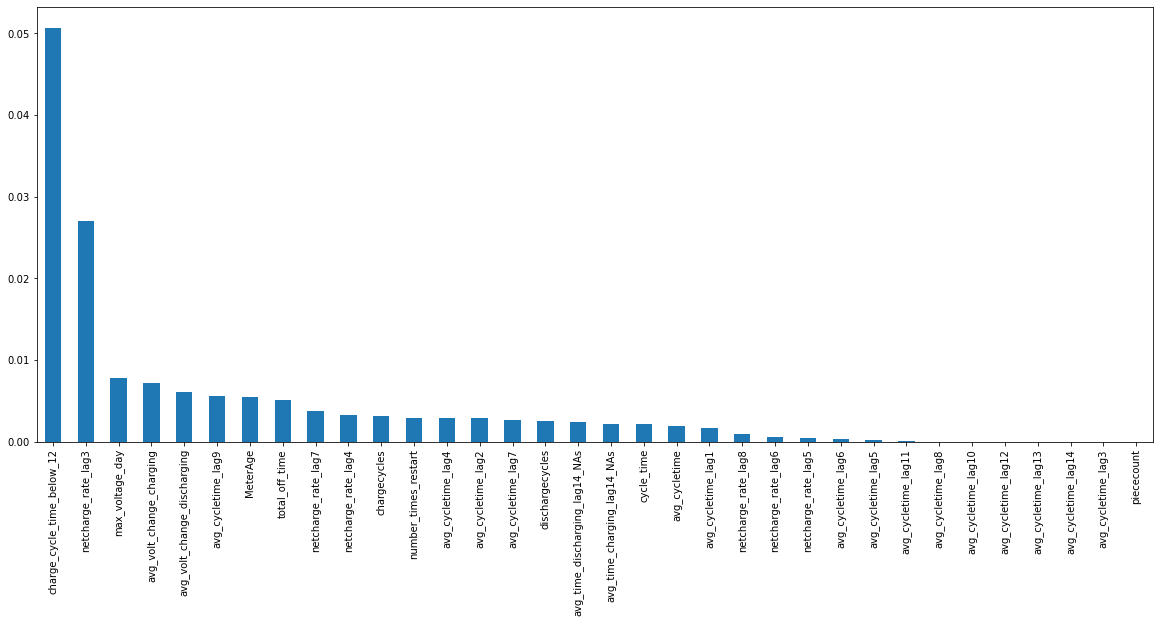

In [47]:
#turn the mutual information scores for the predictor variables into a pd series
train_imputed_mutual_information = pd.Series(train_imputed_mutual_information)

#store the column names of the feature matrix as an index of the pandas series
train_imputed_mutual_information.index = data_transformed.columns

#visualize the mutual scores for each respective feature using bar graphs
#arrange the scores in descending order; left-most = highest scores
train_imputed_mutual_information.sort_values(ascending = False).plot.bar(figsize = (20,8))

___

<center><h1> --- Modelling Phase --- </h1></center> <br>


## Perform train-test split

In [48]:
"""
    Recall that:
    
    We already partition the data set into a feature matrix subset and predictor vector subset in the 
    "Feature Selection & Importance > Creating subsets; predictor matrix and target vector" section.
    
    X = the feature matrix
    y = the target vector

"""

#perform train-test split on the data
#partition data into a training set and testing set for validation
#test set size is = 30% of the data
#training set size is = 70% of the data
X_train, X_test, y_train, y_test = train_test_split(bestft_MUTINF_cols_df, y, test_size = 0.30)

## Random Forest Classifier 

In [49]:
#instantiate the RandomForestClassifier estimator
random_forest = RandomForestClassifier()

#create a list of the scoring metrics we will use to evaluate the model
scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']

#cross validate model
scores = cross_validate(random_forest, X_train, y_train, scoring=scoring, cv=20)

#output the scores for each metric specified in the list called "scoring"
sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [50]:
#create data frame that contains the score output for every scoring metric we specified
models_correlationRF = pd.DataFrame({
    'Model'       : ['Random Forest'],
    'Fitting time': [forest_fit_time],
    'Scoring time': [forest_score_time],
    'Accuracy'    : [forest_accuracy],
    'Precision'   : [forest_precision],
    'Recall'      : [forest_recall],
    'F1_score'    : [forest_f1],
    'AUC_ROC'     : [forest_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_correlationRF.sort_values(by='Accuracy', ascending=False)

Model  Fitting time  Scoring time  Accuracy  Precision    Recall  \
0  Random Forest      5.513048      0.073342  0.800741   0.727306  0.633375   

   F1_score   AUC_ROC  
0  0.775401  0.747556

In [51]:
#train a random forest model using training set
rf_clf = random_forest.fit(X_train, y_train)

### Make predictions with the baseline model

In [52]:
y_pred=rf_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(f"The accuracy score is : {accuracy_score(y_test,y_pred)}")
print(f"The AUC_ROC score is: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))

[[8768  502]
 [1945  935]]
The accuracy score is : 0.7986008230452675
The AUC_ROC score is: 0.6352497977346278
              precision    recall  f1-score   support

       False       0.82      0.95      0.88      9270
        True       0.65      0.32      0.43      2880

    accuracy                           0.80     12150
   macro avg       0.73      0.64      0.66     12150
weighted avg       0.78      0.80      0.77     12150



<u>**What can we make out of the baseline model and the predictions?**</u>

When we consider the imbalance between the target variable's classes, solely relying on accuracy as the metric would not yield the 'best' performing model. Instead, we should use metrics such as the precision score, accuracy score, AUC_ROC score, f1_score (weighted), and balanced accuracy score as possible metrics to use to evaluate the performance of the model. With that said, it goes without saying that there is room for improvement for the model.

## Tune the RandomForestClassifier Model with RandomizedSearchCV

### Define Hyperparameters and parameters for RandomizedSearchCV

In [53]:
"""
    Setting up hyperparameters we want to adjust for tuning the RandomForestClassifier
"""

#add classweight
class_weight = [{0:0.6, 1:2}]

#number of features to consider at every split
max_features = ['log2']

#minimum number of samples required to split a node
min_samples_split = [10,20,50]

#minimum number of samples required at each leaf node
min_samples_leaf = [5,10,20]

In [54]:
#create grid of parameters
grid_RF ={'class_weight': class_weight,
            'max_features': max_features,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf}

In [55]:
#create a list of the scoring metrics we will use to evaluate the model
scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']

### Perform tuning with RandomizedSearchCV

In [56]:
#Instantiate RandomizedSearchCV
clf=RandomizedSearchCV(estimator= random_forest, param_distributions = grid_RF ,cv=10, scoring=scoring, refit = 'f1_weighted' , verbose = 2, n_jobs = 4, random_state = 500)

In [57]:
#run a fit on the training set with the predefined set of parameters + hyperparameters
clf.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'class_weight': [{0: 0.6, 1: 2}],
                                        'max_features': ['log2'],
                                        'min_samples_leaf': [5, 10, 20],
                                        'min_samples_split': [10, 20, 50]},
                   random_state=500, refit='f1_weighted',
                   scoring=['accuracy', 'precision_macro', 'recall_macro',
                            'f1_weighted', 'roc_auc'],
                   verbose=2)

### Make predictions using the tuned model

In [58]:
#make predictions using the trained model
y_pred=clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(f"The accuracy score is : {accuracy_score(y_test,y_pred).mean()}")
print(f"The balanced accuracy score is: {balanced_accuracy_score(y_test, y_pred).mean()}")
print(f"The AUC_ROC score is: {roc_auc_score(y_test, y_pred).mean()}")
print(classification_report(y_test,y_pred))

[[8352  918]
 [1579 1301]]
The accuracy score is : 0.7944855967078189
The balanced accuracy score is: 0.6763534924487594
The AUC_ROC score is: 0.6763534924487594
              precision    recall  f1-score   support

       False       0.84      0.90      0.87      9270
        True       0.59      0.45      0.51      2880

    accuracy                           0.79     12150
   macro avg       0.71      0.68      0.69     12150
weighted avg       0.78      0.79      0.78     12150



### Evaluating the tuned model

In [59]:
#show results of the randomizedsearchCV in pd DataFrame form
pd.DataFrame(clf.cv_results_).T

0  \
mean_fit_time                                                          4.71386   
std_fit_time                                                           0.03133   
mean_score_time                                                       0.106624   
std_score_time                                                         0.00201   
param_min_samples_split                                                     10   
param_min_samples_leaf                                                       5   
param_max_features                                                        log2   
param_class_weight                                              {0: 0.6, 1: 2}   
params                       {'min_samples_split': 10, 'min_samples_leaf': ...   
split0_test_accuracy                                                  0.785891   
split1_test_accuracy                                                  0.808113   
split2_test_accuracy                                                  0.795414   
split3_test_accuracy                                                  0.781658   
split4_test_accuracy                                                  0.785185   
split5_test_accuracy                                                  0.794356   
split6_test_accuracy                                                  0.796825   
split7_test_accuracy                                                  0.797884   
split8_test_accuracy                                                  0.791182   
split9_test_accuracy                                                  0.793298   
mean_test_accuracy                                                    0.792981   
std_test_accuracy                                                     0.007199   
rank_test_accuracy                                                           1   
split0_test_precision_macro                                           0.692193   
split1_test_precision_macro                                           0.728969   
split2_test_precision_macro                                           0.707924   
split3_test_precision_macro                                           0.684637   
split4_test_precision_macro                                           0.690618   
split5_test_precision_macro                                           0.705802   
split6_test_precision_macro                                           0.710102   
split7_test_precision_macro                                           0.711908   
split8_test_precision_macro                                           0.701343   
split9_test_precision_macro                                           0.704893   
mean_test_precision_macro                                             0.703839   
std_test_precision_macro                                              0.012012   
rank_test_precision_macro                                                    1   
split0_test_recall_macro                                              0.665202   
split1_test_recall_macro                                              0.693077   
split2_test_recall_macro                                              0.680529   
split3_test_recall_macro                                              0.655461   
split4_test_recall_macro                                              0.660979   
split5_test_recall_macro                                              0.668547   
split6_test_recall_macro                                              0.678756   
split7_test_recall_macro                                              0.672451   
split8_test_recall_macro                                               0.67778   
split9_test_recall_macro                                              0.678464   
mean_test_recall_macro                                                0.673125   
std_test_recall_macro                                                 0.010385   
rank_test_recall_macro                                                       9   
split0_test_f1_weighted                                    

In [60]:
#get best parameters and store in a pd DataFrame
pd.DataFrame(clf.best_params_)

min_samples_split  min_samples_leaf max_features  class_weight
0                 10                 5         log2           0.6
1                 10                 5         log2           2.0

In [61]:
#view best score of the model in terms of percentage
print(clf.best_score_*100)

78.45798127610074


In [62]:
#check which combinations of hyperparameters created the 'best' model
print(clf.best_estimator_)

RandomForestClassifier(class_weight={0: 0.6, 1: 2}, max_features='log2',
                       min_samples_leaf=5, min_samples_split=10)


In [63]:
#fit the randomforest model again and store the best estimator into best_clf
best_clf = clf.best_estimator_

### Feature importance post-hyperparameter tuning

In [64]:
#retrieve feature importance scores
clf.best_estimator_.feature_importances_

array([0.16472653, 0.08896806, 0.08963899, 0.08634025, 0.09721267,
       0.09292074, 0.08949658, 0.00828672, 0.20001295, 0.08239652])

In [65]:
#create a data frame
#show the features used in the model and their corresponding feature importance scores 
feature_importances = pd.DataFrame(best_clf.feature_importances_,index = X_train.columns,columns=['Importance'])

In [66]:
#look at the feature importance values for each feature used in the RandomForest classifer model
feature_importances.T.sort_values(by = 'Importance', axis = 1, ascending = False)

netcharge_rate_lag3  charge_cycle_time_below_12  \
Importance             0.200013                    0.164727   

            avg_volt_change_charging  avg_volt_change_discharging  \
Importance                  0.097213                     0.092921   

            total_off_time  max_voltage_day  chargecycles  \
Importance        0.089639         0.089497      0.088968   

            number_times_restart  netcharge_rate_lag5  \
Importance               0.08634             0.082397   

            avg_time_charging_lag14_NAs  
Importance                     0.008287

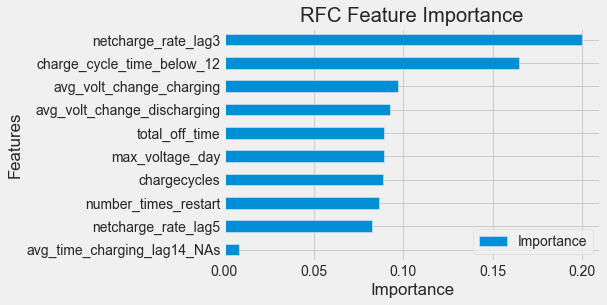

In [111]:
#import matplotlib
import matplotlib

#set styles
sns.set_style('dark')
matplotlib.style.use('fivethirtyeight')

#visualize feature importance
barplotft = feature_importances.sort_values(by = 'Importance', axis = 0, ascending = True).plot(kind = 'barh', title = 'RFC Feature Importance')
plt.xlabel('Importance');
plt.ylabel('Features');

## Alt. approach:  Oversampling with imblearn's RandomOverSampler

### Oversample the minority

In [68]:
#import RandomOverSampler; perform oversampling
from imblearn.over_sampling import RandomOverSampler

#import Counter;
from collections import Counter

y_train.value_counts()

os = RandomOverSampler(.75)
X_train_os, y_train_os = os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit{}".format(Counter(y_train_os)))

The number of classes before fit Counter({False: 21829, True: 6521})
The number of classes after fitCounter({False: 21829, True: 16371})


### Perform tuning with RandomizedSearchCV

In [69]:
"""
    We will be using the param_distributions that we defined in the previous section; grid_RF
"""


#Instantiate RandomizedSearchCV
os_clf=RandomizedSearchCV(estimator= random_forest, param_distributions = grid_RF ,cv=10, scoring=scoring, refit = 'f1_weighted' , verbose = 2, n_jobs = 4, random_state = 500)

In [70]:
#fit the randomforest estimator on the oversampled data
os_clf.fit(X_train_os, y_train_os)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'class_weight': [{0: 0.6, 1: 2}],
                                        'max_features': ['log2'],
                                        'min_samples_leaf': [5, 10, 20],
                                        'min_samples_split': [10, 20, 50]},
                   random_state=500, refit='f1_weighted',
                   scoring=['accuracy', 'precision_macro', 'recall_macro',
                            'f1_weighted', 'roc_auc'],
                   verbose=2)

### Make predictions using tuned model on synthetically oversampled data

In [71]:
#make predictions using the tuned model, but this time fit it on the oversampled data sets and print out metrics
y_pred=os_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(f"The accuracy score is : {accuracy_score(y_test,y_pred)}")
print(f"The balanced accuracy score is: {balanced_accuracy_score(y_test, y_pred)}")
print(f"The AUC_ROC score is: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))

[[7475 1795]
 [1225 1655]]
The accuracy score is : 0.751440329218107
The balanced accuracy score is: 0.6905086974110033
The AUC_ROC score is: 0.6905086974110032
              precision    recall  f1-score   support

       False       0.86      0.81      0.83      9270
        True       0.48      0.57      0.52      2880

    accuracy                           0.75     12150
   macro avg       0.67      0.69      0.68     12150
weighted avg       0.77      0.75      0.76     12150



### Evaluating the tuned model using oversampled data

In [72]:
#show results of the randomizedsearchCV in pd DataFrame form
pd.DataFrame(os_clf.cv_results_).T

0  \
mean_fit_time                                                         6.893421   
std_fit_time                                                          0.080075   
mean_score_time                                                        0.14628   
std_score_time                                                        0.000816   
param_min_samples_split                                                     10   
param_min_samples_leaf                                                       5   
param_max_features                                                        log2   
param_class_weight                                              {0: 0.6, 1: 2}   
params                       {'min_samples_split': 10, 'min_samples_leaf': ...   
split0_test_accuracy                                                  0.821204   
split1_test_accuracy                                                  0.840838   
split2_test_accuracy                                                  0.822251   
split3_test_accuracy                                                   0.83089   
split4_test_accuracy                                                  0.859686   
split5_test_accuracy                                                  0.873822   
split6_test_accuracy                                                  0.855236   
split7_test_accuracy                                                   0.87644   
split8_test_accuracy                                                  0.865445   
split9_test_accuracy                                                  0.867801   
mean_test_accuracy                                                    0.851361   
std_test_accuracy                                                     0.019932   
rank_test_accuracy                                                           1   
split0_test_precision_macro                                            0.82207   
split1_test_precision_macro                                           0.839767   
split2_test_precision_macro                                           0.822556   
split3_test_precision_macro                                           0.831882   
split4_test_precision_macro                                           0.870848   
split5_test_precision_macro                                           0.882708   
split6_test_precision_macro                                           0.867698   
split7_test_precision_macro                                           0.885784   
split8_test_precision_macro                                            0.87544   
split9_test_precision_macro                                           0.877943   
mean_test_precision_macro                                              0.85767   
std_test_precision_macro                                              0.024298   
rank_test_precision_macro                                                    1   
split0_test_recall_macro                                              0.828743   
split1_test_recall_macro                                              0.846762   
split2_test_recall_macro                                              0.829278   
split3_test_recall_macro                                              0.838746   
split4_test_recall_macro                                              0.874636   
split5_test_recall_macro                                              0.887844   
split6_test_recall_macro                                              0.870742   
split7_test_recall_macro                                              0.890746   
split8_test_recall_macro                                              0.879904   
split9_test_recall_macro                                              0.882302   
mean_test_recall_macro                                                 0.86297   
std_test_recall_macro                                                 0.023245   
rank_test_recall_macro                                                       1   
split0_test_f1_weighted                                    

In [73]:
#get best parameters and store in a pd DataFrame
pd.DataFrame(os_clf.best_params_)

min_samples_split  min_samples_leaf max_features  class_weight
0                 10                 5         log2           0.6
1                 10                 5         log2           2.0

In [74]:
#view best score of the model in terms of percentage
print(os_clf.best_score_*100)

85.19317789518226


In [75]:
#check which combinations of hyperparameters created the 'best' model
print(os_clf.best_estimator_)

RandomForestClassifier(class_weight={0: 0.6, 1: 2}, max_features='log2',
                       min_samples_leaf=5, min_samples_split=10)


In [76]:
#fit the randomforest model again and store the best estimator into os_best_clf
best_os_clf = clf.best_estimator_

### Feature importance post-ovesampling and hyperparameter tuning

In [77]:
#retrieve feature importance scores
os_clf.best_estimator_.feature_importances_

array([0.15317394, 0.09405364, 0.09803789, 0.09529381, 0.10213914,
       0.09704192, 0.09722159, 0.00742772, 0.16545918, 0.09015118])

In [78]:
#create a data frame
#show the features used in the model and their corresponding feature importance scores 
os_feature_importances = pd.DataFrame(best_os_clf.feature_importances_,index = X_train.columns,columns=['Importance'])

#look at the feature importance values for each feature used in the RandomForest classifer model
feature_importances.T.sort_values(by = 'Importance', axis = 1, ascending = False)

netcharge_rate_lag3  charge_cycle_time_below_12  \
Importance             0.200013                    0.164727   

            avg_volt_change_charging  avg_volt_change_discharging  \
Importance                  0.097213                     0.092921   

            total_off_time  max_voltage_day  chargecycles  \
Importance        0.089639         0.089497      0.088968   

            number_times_restart  netcharge_rate_lag5  \
Importance               0.08634             0.082397   

            avg_time_charging_lag14_NAs  
Importance                     0.008287

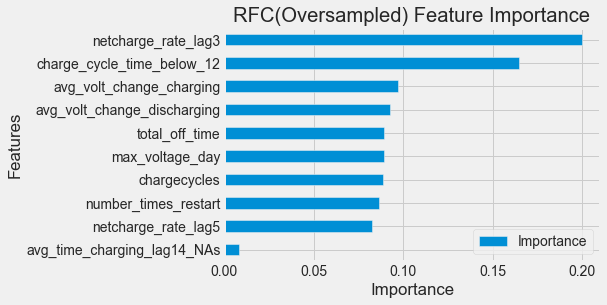

In [79]:
#import matplotlib
import matplotlib

#set styles
sns.set_style('dark')
matplotlib.style.use('fivethirtyeight')

#visualize feature importance
osbarplotft = os_feature_importances.sort_values(by = 'Importance', axis = 0, ascending = True).plot(kind = 'barh', title = 'RFC(Oversampled) Feature Importance')
plt.xlabel('Importance');
plt.ylabel('Features');

<u>**So, which iteration of the RandomForestClassifier model was the best?**</u>

Holistically assessing the balanced accuracy score, AUC_ROC score, weighted precision score, weighted recall score, and weighted f-1 score of all iterations of the Random Forest Classifier model, the 2nd iteration of the RandomForestClassifier model (CTRL+F to quickly locate best_clf) - where we simply adjusted the classweights for each of the 2 classes in the fail_7 target variable - was the 'best' model.<br>

Therefore, we will be using the 2nd iteration (best_clf) moving forward.

## Understanding the Model with the Help of LIME

### Setting up with LIME

In [80]:
#create list that contains the names of the columns that are all boolean 
categorical = list(X_train.select_dtypes(bool).columns)

#create data frame
categoricaldf = X_train[categorical]

#get column name
categoricaldf.columns

# find the index number of the categorical/boolean column in our X_train using get_loc
cat_ix = (X_train.columns.get_loc('charge_cycle_time_below_12'))

#print out the index of the boolean/categorical column
print(cat_ix)

0


In [81]:
#import pickle; serializing and de-serializing Python object structure
import pickle

#create a dump file
pickle.dump(best_clf, open("classifier.pkl", 'wb'))

In [82]:
#import lime and lime_tabular 
import lime

#import lime_tabular ; explain predicttion on tabular data
from lime import lime_tabular

### Break the model down

In [83]:
#explain predictions on tabular data
interpretor = lime_tabular.LimeTabularExplainer(
    training_data = np.array(X_train),
    feature_names = X_train.columns,
    mode = 'classification',
    categorical_features = [0],
    class_names = ['not failing in 7 days','failing in 7 days'])

#### A case of when the model predicts an instance to be 'True' or 'the meter will fail in 7 days'

In [84]:
#return an array where all predictions of the model on the testing set is True or "1"
np.where(y_pred == True)

(array([    0,     2,     3, ..., 12139, 12147, 12148], dtype=int64),)

In [85]:
#retrieve given row [i]
X_test.iloc[]

charge_cycle_time_below_12            True
chargecycles                          72.0
total_off_time                   22.578947
number_times_restart              2.263158
avg_volt_change_charging        348.109474
avg_volt_change_discharging     347.243684
max_voltage_day                4149.157895
avg_time_charging_lag14_NAs          False
netcharge_rate_lag3                  -0.01
netcharge_rate_lag5                   0.03
Name: 32239, dtype: object

In [108]:
#generate explanations for a prediction
exp = interpretor.explain_instance(
    data_row = X_test.iloc[0],
    predict_fn = best_clf.predict_proba
)

#output explanation object
exp.show_in_notebook(show_table = True)

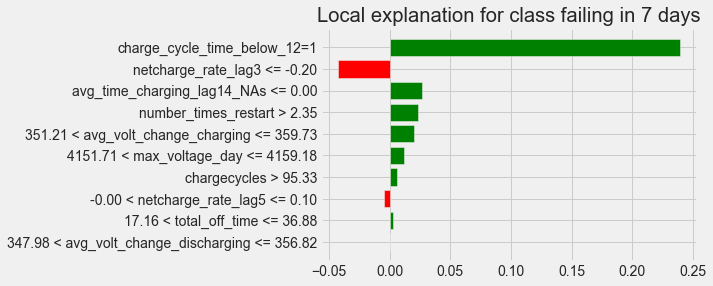

In [109]:
#create an expanded and more detailed version of the middle plot from the explain_instance graph
fig = exp.as_pyplot_figure()

#### A case of when the model predicts an instance to be 'False' or 'the meter won't fail in 7 days'

In [88]:
#return an array where all predictions of the model on the testing set is False or "0"
np.where(y_pred == False)

(array([    1,     4,     5, ..., 12145, 12146, 12149], dtype=int64),)

In [89]:
#retrieve given row [i]
X_test.iloc[12149]

charge_cycle_time_below_12           False
chargecycles                     91.333333
total_off_time                   10.777778
number_times_restart              1.277778
avg_volt_change_charging        341.662222
avg_volt_change_discharging     342.372222
max_voltage_day                4148.166667
avg_time_charging_lag14_NAs          False
netcharge_rate_lag3               0.583333
netcharge_rate_lag5                  -0.73
Name: 19117, dtype: object

In [90]:
#generate explanations for a prediction
exp_f = interpretor.explain_instance(
    data_row = X_test.iloc[2],
    predict_fn = best_clf.predict_proba
)

#output explanation object
exp.show_in_notebook(show_table = True)

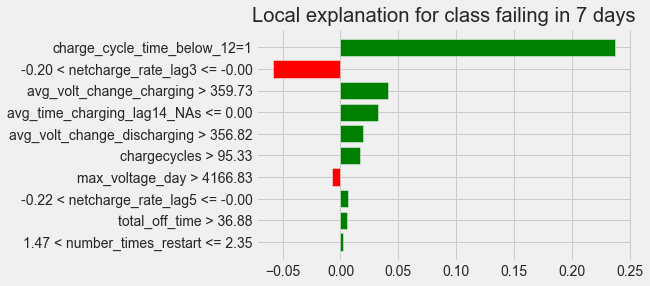

In [91]:
#create an expanded and more detailed version of the middle plot from the explain_instance graph
fig = exp_f.as_pyplot_figure()

___

<center><h1> --- Forecast --- </h1></center> <br>


# Mirror all the pre-modelling work done on the train.csv data to the data in the test.csv

In [92]:
#convert LastRecord and Date Deployed columns to datetime64 objects
test.LastRecord = pd.to_datetime(test.LastRecord)
test['Date Deployed'] = pd.to_datetime(test['Date Deployed'])

In [93]:
#Subtract difference between the dates in the LastRecord and Date Deployed columns
test['MeterAge'] = test['LastRecord'] - test['Date Deployed']

#convert the difference into weeks
test['MeterAge'] = test['MeterAge'] / np.timedelta64 (1, 'W')

#round the MeterAge column values, 2 places after decimal pt
test['MeterAge'] = round(test['MeterAge'],2)

#drop the LastRecord and Date Deployed columns
test = test.drop(['LastRecord', 'Date Deployed'], axis = 1)

In [94]:
#identify all the columns with missing values
#create a list of the names of the columns with missing values
columns_with_nulls_test = test.columns[test.isnull().any()].tolist()

#how many columns with missing values are there?
#len(columns_with_nulls_test)

#create a subset data frame
#data frame contains the columns with missing values
df_of_missing_test = test[columns_with_nulls_test]

#double-check the shape of the data frame to make sure that there are 25 columns
#df_of_missing_test.shape <- should output 25 

#create a data frame by concatenating the columns with missing values and their respective missing value indicator column
#add _NA at the end of every column name to denote that the column is an indicator column
indicators_for_df_of_missing_test = pd.concat([df_of_missing_test, df_of_missing_test.isnull().astype(bool).add_suffix('_NAs')], axis=1)

#sort columns in descending order
#store the df to a shorter, much more legible variable name
missing_ind_df_test = indicators_for_df_of_missing_test.sort_index(axis = 1, ascending = False)

#drop the columns in the columns_with_nulls_test list;
#keep the missing values indicator columns in the dataframe
missing_ind_df_test = missing_ind_df_test.drop(columns_with_nulls_test, axis = 1)

In [95]:
#instantiate KNNImputer
#set the n_neighbors = 5; impute the value of the missing record by using its 5 nearest neighbors as reference
#include add_indicator = True; indicate missing values
knn_imputer_test = KNNImputer(n_neighbors = 5)

#perform imputation using KNNImputer w/ nearest neighbor = 5 
imputer_on_test = knn_imputer_test.fit_transform(test)

In [96]:
#convert the numpy array version of the 'train' data frame outputted by the imputation back to a dataframe
post_impute_test= pd.DataFrame(imputer_on_test, columns = test.columns)

In [97]:
#convert charge_cycle_time_below_12 column values to bool
post_impute_test['charge_cycle_time_below_12'] = post_impute_test['charge_cycle_time_below_12'].astype(bool)

In [98]:
#concatenate the post_impute_train data frame and the missing_ind_df data frame horizontally
test_imputed = pd.concat([post_impute_test, missing_ind_df_test], axis = 1)

In [99]:
#create avg_cycletime_lag[i] columns, where i is the lag day
test_imputed['avg_cycletime_lag1'] = test_imputed['avg_time_charging_lag1']+ test_imputed['avg_time_discharging_lag1']
test_imputed['avg_cycletime_lag2'] = test_imputed['avg_time_charging_lag2']+ test_imputed['avg_time_discharging_lag2']
test_imputed['avg_cycletime_lag3'] = test_imputed['avg_time_charging_lag3']+ test_imputed['avg_time_discharging_lag3']
test_imputed['avg_cycletime_lag4'] = test_imputed['avg_time_charging_lag4']+ test_imputed['avg_time_discharging_lag4']
test_imputed['avg_cycletime_lag5'] = test_imputed['avg_time_charging_lag5']+ test_imputed['avg_time_discharging_lag5']
test_imputed['avg_cycletime_lag6'] = test_imputed['avg_time_charging_lag6']+ test_imputed['avg_time_discharging_lag6']
test_imputed['avg_cycletime_lag7'] = test_imputed['avg_time_charging_lag7']+ test_imputed['avg_time_discharging_lag7']
test_imputed['avg_cycletime_lag8'] = test_imputed['avg_time_charging_lag8']+ test_imputed['avg_time_discharging_lag8']
test_imputed['avg_cycletime_lag9'] = test_imputed['avg_time_charging_lag9']+ test_imputed['avg_time_discharging_lag9']
test_imputed['avg_cycletime_lag10'] = test_imputed['avg_time_charging_lag10']+ test_imputed['avg_time_discharging_lag10']
test_imputed['avg_cycletime_lag11'] = test_imputed['avg_time_charging_lag11']+ test_imputed['avg_time_discharging_lag11']
test_imputed['avg_cycletime_lag12'] = test_imputed['avg_time_charging_lag12']+ test_imputed['avg_time_discharging_lag12']
test_imputed['avg_cycletime_lag13'] = test_imputed['avg_time_charging_lag13']+ test_imputed['avg_time_discharging_lag13']
test_imputed['avg_cycletime_lag14'] = test_imputed['avg_time_charging_lag14']+ test_imputed['avg_time_discharging_lag14']

#create a list of the columns that were used to create the avg_cycletime_lag[i] columns
redundant_time_dANDcharging_test= ['avg_time_charging_lag1','avg_time_discharging_lag1','avg_time_charging_lag2','avg_time_discharging_lag2','avg_time_charging_lag3','avg_time_discharging_lag3',
             'avg_time_charging_lag4','avg_time_discharging_lag4','avg_time_charging_lag5','avg_time_discharging_lag5','avg_time_charging_lag6','avg_time_discharging_lag6',
             'avg_time_charging_lag7','avg_time_discharging_lag7','avg_time_charging_lag8','avg_time_discharging_lag8','avg_time_charging_lag9','avg_time_discharging_lag9',
             'avg_time_charging_lag10','avg_time_discharging_lag10','avg_time_charging_lag11','avg_time_discharging_lag11','avg_time_charging_lag12',
             'avg_time_discharging_lag12','avg_time_charging_lag13','avg_time_discharging_lag13','avg_time_charging_lag14','avg_time_discharging_lag14']

#drop the columns within the list created above
test_imputed.drop(redundant_time_dANDcharging_test, inplace=True, axis=1)  

In [100]:
#create netcharge_rate_lag[i] columns, where i is the lag day
test_imputed['netcharge_rate_lag3'] = test_imputed['charging_rate_lag3']+ test_imputed['discharging_rate_lag3']
test_imputed['netcharge_rate_lag4'] = test_imputed['charging_rate_lag4']+ test_imputed['discharging_rate_lag4']
test_imputed['netcharge_rate_lag5'] = test_imputed['charging_rate_lag5']+ test_imputed['discharging_rate_lag5']
test_imputed['netcharge_rate_lag6'] = test_imputed['charging_rate_lag6']+ test_imputed['discharging_rate_lag6']
test_imputed['netcharge_rate_lag7'] = test_imputed['charging_rate_lag7']+ test_imputed['discharging_rate_lag7']
test_imputed['netcharge_rate_lag8'] = test_imputed['discharging_rate_lag8'] * -1

#create a list of the columns that were used to create the netcharge_rate_lag[i] columns
redundant_dANDcharge_rate_test = ['charging_rate_lag3','discharging_rate_lag3','charging_rate_lag4','discharging_rate_lag4',
                    'charging_rate_lag5','discharging_rate_lag5','charging_rate_lag6','discharging_rate_lag6',
                    'charging_rate_lag7','discharging_rate_lag7','discharging_rate_lag8']

#drop the columns within the list created above
test_imputed.drop(redundant_dANDcharge_rate_test, inplace = True, axis = 1)

In [101]:
#create the avg_cycletime column
test_imputed['avg_cycletime'] = test_imputed['avg_time_charging'] + test_imputed['avg_time_discharging']

#create a list of the columns used to create the avg_cycletime column
redundant_dANDcharging_time_test = ['avg_time_charging','avg_time_discharging']

#drop the columns within the list created above
test_imputed.drop(redundant_dANDcharging_time_test, inplace = True, axis =1)

# Forecasting the fail_7 predictions for the test.csv data

In [102]:
#retrieve the column names after feature selection was performed on the train.csv data set
cols_from_train = bestft_MUTINF_cols_df.columns.tolist()

#print the list to see what columns are in the data frame that we used to train the model -- post feature selection
print(cols_from_train)

['charge_cycle_time_below_12', 'chargecycles', 'total_off_time', 'number_times_restart', 'avg_volt_change_charging', 'avg_volt_change_discharging', 'max_voltage_day', 'avg_time_charging_lag14_NAs', 'netcharge_rate_lag3', 'netcharge_rate_lag5']


In [103]:
#create subset data frame of test_imputed
#match the columns with the columns in the data frame used to train the model
testcols_for_pred = test_imputed[test_imputed.columns & cols_from_train]

In [104]:
#use the model we trained to forecast the fail_7 column for the test.csv data
y_testcsv_pred = best_clf.predict(testcols_for_pred)

In [105]:
#print outputs of the forecast
print(y_testcsv_pred)

[ True False  True ... False  True False]


In [106]:
#instantiate a pd DataFrame object to store the deviceid column and the respective forecast for each corresponding deviceid
forecastdf = pd.DataFrame()

#add the deviceid columm into the dataframe 
forecastdf['deviceid'] = test_imputed['deviceid']

#add the array of predicted values for fail_7 column of the test.csv
forecastdf['fail_7'] = y_testcsv_pred

#double check dimensions
forecastdf.head()
forecastdf.shape, test.shape #check to see if the number of rows match up!

((4500, 2), (4500, 53))